# Occupational Stress - Assignment 2 - Team 3 

![University of Groningen](https://i2.wp.com/www.riskenbusiness.nl/wp-content/uploads/2018/02/rijksuniversiteit_Groningen.jpg?fit=2804%2C1072&ssl=1)

## Team 3
- Marieke de Roos - S2747197
- Jurgen Harperink - S3809633
- Tobias Schiphorst - S4917340 

# 1. Introduction and Exploratory Analysis

This report evaluates four potential decision tree models that could be used to predict occupational stress. The aim of the report is to apply bias management to eventually develop a model that can help employers and employees alike to predict stress in the workplace. Eventually, this can help to improve overall employee wellbeing.

In the process of creating the best model, we take bias management into account. Bias management in AI focuses on that a model cannot be biased based on sensitive attributes such as a participants' age or gender. This means that the model should be developed in such a way that these sensitive attributes pay no role in the eventual prediction that the model makes.

In order to find the best suiting model, four models are created and three different ways of analysis are used. First of all, the models are evaluated based on an 'aware' model and a 'weighted' model. By first focusing on an 'aware' model, we can see the influence of the sensitive attributes in the decision making process. After that, we look at how we can weight the different attributes in order to create a fair model. 

Within this process, we look at correlations between all attributes and seek for indicators that help to best predict whether the subject will or will not experience feelings of stress. We start with an exploratory analysis, followed by a correlation analysis. After these analyses, we start by developing four different decision tree models. Then, we evaluate on these models by defining amongst all their accuracy rates and ROC_AUC values, a classification report and precision recall curves. Based on an evaluation of these different classifications we choose a preferred model, which we use to explain the decision tree with. Then, we look at which model seems best suitable when looking at decision tree transparency. In the fourth chapter, we apply bias management to the models by looking at the influence of the sensitive attributes and by developing the model according to the outcomes. Last, we end the report with discussion the overall conclusion and our recommendations.

Let's first start by importing the initial modules.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
! pip install fairlearn
! pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 KB 3.3 MB/s eta 0:00:00


After successfully importing the required modules we import the dataset and take specific columns that we will use in our future analysis down the line. 

In [2]:
df_may = pd.read_csv('https://tschiphorst.nl/may2014.csv', sep=',', index_col=0)

In [3]:
cols = ['subject', 'label', 
        'age','gender_ female',
        'height', 'weight',
        'coffee_today_YES', 'sport_today_YES', 'smoker_YES',
        'BVP_std', 
        'EDA_mean', 'EDA_std', 
        'EDA_phasic_mean','EDA_phasic_std', 
        'EDA_smna_mean','EDA_smna_std', 
        'EDA_tonic_mean','EDA_tonic_std',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

df_may = df_may[cols]

The `label` column is mainly important and indicates the observed feelings of the specific subject. For this case we will only look at the feelings of having `no stress` or feeling `stress`. Therefore, we will remove the undefined feelings from the dataset.  

In [4]:
# Check which labels are used
df_may['label'].value_counts()

1    628
2    355
0    195
Name: label, dtype: int64

In [5]:
df_may = df_may.loc[~(df_may['label'] == 0)] # remove the undefined feelings of the subjects

After removing all the undefined feelings from the dataset, we decide to replace the labels. The the current dataset format provided to us in the case the following labels are defined:
- baseline (no stress) = 1
- stress = 2

To make analysis more clear we preperate the data by giving the baseline feeling (1) the value 0 and the stress (2) the value 1 respectivly. 

In [6]:
df_may['label'] = df_may['label'].replace({1: 0}) # change the baseline/normal feeling from 1 to 0
df_may['label'] = df_may['label'].replace({2: 1}) # change the stress feeling from 2 to 1

<ipython-input-6-21d734906c8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_may['label'] = df_may['label'].replace({1: 0}) # change the baseline/normal feeling from 1 to 0
<ipython-input-6-21d734906c8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_may['label'] = df_may['label'].replace({2: 1}) # change the stress feeling from 2 to 1


Now the label are defined as:
- no stress = 0
- stress = 1

Next, we take an look towards `gender` and if the subject had coffee, did sports or feels ill today and if he or she is a smoker. As the dataset contains an binary columns called `gender_ female`, `coffee_today_YES`, `sport_today_YES` and `smoker_YES` indicating if the subject is female (1) or not (0), if he or she drank coffee or worked out and or he or she is an smoker. To make this more clear we rename these above columns.   

In [7]:
df_may = df_may.rename(columns = {'gender_ female':'gender'})
df_may = df_may.rename(columns = {'coffee_today_YES':'coffee'})
df_may = df_may.rename(columns = {'sport_today_YES':'sport'})
df_may = df_may.rename(columns = {'smoker_YES':'smoker'})

Check for duplicates.

In [8]:
print(len(df_may[df_may.duplicated()]), 'duplicates found')

0 duplicates found


In [9]:
df_may.head()

,subject,label,age,gender,height,weight,coffee,sport,smoker,BVP_std,...,EDA_std,EDA_phasic_mean,EDA_phasic_std,EDA_smna_mean,EDA_smna_std,EDA_tonic_mean,EDA_tonic_std,Resp_std,TEMP_mean,TEMP_slope
0,2,0,27,0,175,80,0,0,0,107.648359,...,0.141481,1.824289,1.088328,1.284376,1.952823,1.232164,0.997487,2.935617,35.817091,-0.000169
1,2,0,27,0,175,80,0,0,0,118.742089,...,0.091882,2.109146,1.223528,1.467865,2.852510,0.377615,1.172221,2.843123,35.797568,-0.000789
2,2,0,27,0,175,80,0,0,0,42.190039,...,0.102315,0.152828,0.128896,0.105091,0.244891,1.727696,0.293389,1.700333,35.712909,-0.000717
3,2,0,27,0,175,80,0,0,0,41.606872,...,0.046391,0.177595,0.126167,0.110786,0.199704,0.987927,0.042388,1.483260,35.700811,0.000075
4,2,0,27,0,175,80,0,0,0,43.121633,...,0.034540,0.035014,0.039616,0.026716,0.114738,0.772262,0.077628,1.501585,35.744727,0.000442


Now our dataset is fully prepared to be used for our analysis. The next step is to explore the different attributes within the provide data. 

## 1.1 Exploratory Analysis
let's first describe the data per column:  

In [10]:
df_may.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1164
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          983 non-null    int64  
 1   label            983 non-null    int64  
 2   age              983 non-null    int64  
 3   gender           983 non-null    int64  
 4   height           983 non-null    int64  
 5   weight           983 non-null    int64  
 6   coffee           983 non-null    int64  
 7   sport            983 non-null    int64  
 8   smoker           983 non-null    int64  
 9   BVP_std          983 non-null    float64
 10  EDA_mean         983 non-null    float64
 11  EDA_std          983 non-null    float64
 12  EDA_phasic_mean  983 non-null    float64
 13  EDA_phasic_std   983 non-null    float64
 14  EDA_smna_mean    983 non-null    float64
 15  EDA_smna_std     983 non-null    float64
 16  EDA_tonic_mean   983 non-null    float64
 17  EDA_tonic_std  

Description on the data:
- *subject* : SX, the subject ID, 17 subjects participated in the study. However, due to sensor malfunction, data of two subjects (S1 and S12) had to be discarded. 
- *label* : ID of the study providing the feeling of the subject in which 0 = baseline (no stress) and 1 = feeling stress
- *age* : age of the subject
- *gender* : gender of the subject
- *height* : height of the subject
- *weight* : weight of the subject
- *coffee* : indicates if the subject had coffee today or not
- *sport* : indicates if the subject worked out today or not
- *smoker* : indicates if the subject is an smoker
- *BVP* : Data from photoplethysmograph
- *EDA* : Sensor data from the EDA sensor bands 
- *Resp* : RESPIRATION (%) of the subject
- *TEMP* : temperature in celsius

In [11]:
print('average observations per subject:', df_may['subject'].value_counts().mean())
print('number of subjects are', df_may['subject'].value_counts().count())

average observations per subject: 65.53333333333333
number of subjects are 15


As we can see, each subject has around 66 observations based on 15 different subjects within the dataset, this means that 66 measurements by self-assessment have been taken by each subject for every 90 minutes of their deskwork. 

As one of the sensative attributes is `gender`, a question that we can ask ourselves is whether there is a `gender` inbalance within the observations between male and female.  

Let's take a look what the gender distributions between these observations are by looking at how many Male/Female observations are present in the data. 

In [12]:
df_may['gender'].value_counts()

0    783
1    200
Name: gender, dtype: int64

Based on the `gender` attribute we can observe that the data contains in total 983 observations of which 783 are marked with male (`0`) and 200 marked as female (`1`), which indicates a gender inbalance within the data. This finding could result in biased outcomes when doing analysis that includes gender. 

As described in the case, unequal accuracy exists in the current stress models for people of different age groups. Hence, besides gender, the different age groups the subjects fall into should be further analysed. 

The best next step is to find out the distribution of `Age` based on the `Gender` column.  

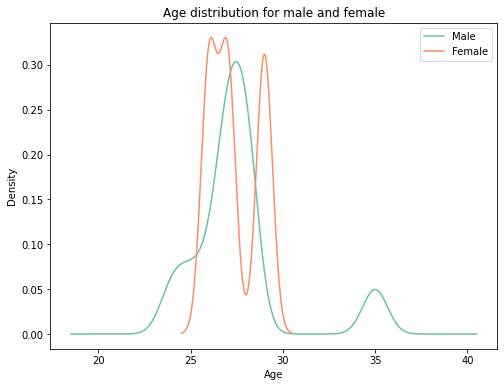

In [13]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Age distribution for male and female')
df_may.groupby('gender').age.plot(kind='kde')
ax.set_xlabel('Age')
ax.legend(['Male', 'Female'])

The figure above shows a Kernel density estimation to determine the probability density function of the variable `Age` grouped by Nonparametic `Gender` column. Based on this distribution we can see that most observations are densed between the ages of 25 until 30. 

Looking specifically at the the Female distribution, we observe that it is exclusively distributed between the age of 25 until around 30 years old. The Male distribution has younger and older entries than the Female distribution, starting from around 23 years old up to 35 years old, including a gap between the ages 30 - 34.

Based on this analysis we can conclude that the age distribution within the dataset is mostly centered between 25 and 30 years old. This confirms the statement made in the case of having unequal accuracy for people of different age groups, which means that there is a probablity that the results model predictions are overly biased towards the age groups between 25 and 30. 

Next to the unequal distribution of different ages in the case, it is stated in the case that overall younger people tend to have perceived a higher mean in heartrate variability, we expect that the dataset is quite sensitive to having very high stress rate levels.

Besides stress in different age groups, the personal attributes also consider `height` & `weight`, and lifestyle attributes such as being an `smoker`, doing `sport` and drinking `coffee`.

The next step within this exploratory analysis is to check the different distributions on the following age groups of up to 27 years old, and 28 years or older more specifically. 

In [14]:
# bin age into groups to make binary (0: under 27)
df_may['age'] = np.where(df_may['age']>=28, 1, 0)

First we devide the age column into age groups using the following binary notation:
- 0 = under 27 years old
- 1 = 28 or older

Based on these age groups we can further explore the `age` and `gender` distributions between them.

Text(0.5, 1.0, 'No stress/stress freq. in the dataset')

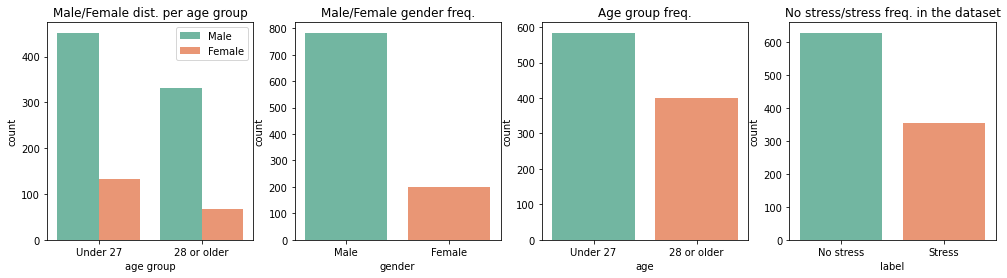

In [15]:
# plot sample distributions
fig, ax = plt.subplots(1,4)
fig.set_size_inches(17, 4)
sns.countplot(ax=ax[0], x=df_may['age'].map({0:'Under 27', 1:'28 or older'}), hue=df_may.gender)
ax[0].set_title('Male/Female dist. per age group')
ax[0].set_xlabel('age group')
ax[0].legend(['Male', 'Female'])

sns.countplot(ax=ax[1], x=df_may['gender'].map({0:'Male', 1:'Female'}))
ax[1].set_title('Male/Female gender freq.')

sns.countplot(ax=ax[2], x=df_may['age'].map({0:'Under 27', 1:'28 or older'}))
ax[2].set_title('Age group freq.')

sns.countplot(ax=ax[3], x=df_may['label'].map({0:'No stress', 1:'Stress'}))
ax[3].set_title('No stress/stress freq. in the dataset')

The left figure presents the `gender` distribution per `age group`, the second figure the `gender` distribution within the dataset. Starting with the left figure, it can be confirmed that females are highly underrepresented within the data. Besides this, the age group under 27 years old is more represented in general compared to the other age group (third figure). As stated in the previous analysis, woman are highly underrepesented compared to men in the data. Of the total number of observations in the data between 300 a 400 times a subject indicated to having stressfull feelings, compared to over 600 entries that indicated no stress.

Next, we will look at the personal and lifestyle attributes of `smoker`, `sport`, `coffee`, `height` and `weight` for each `gender` group in order to find an possible relation between lifestyle and `gender`.  

Text(0.5, 1.0, 'Weight / Height based on gender')

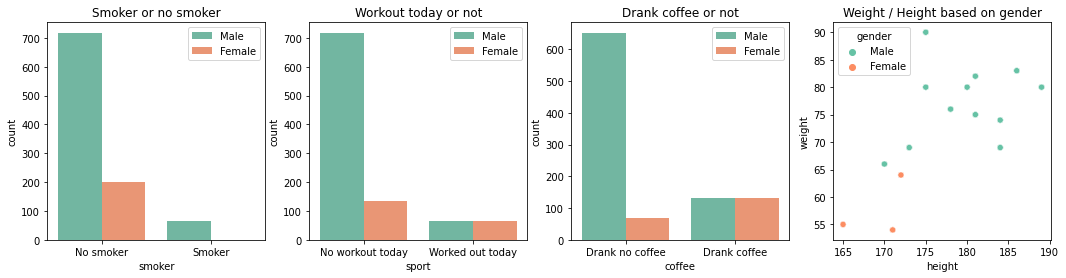

In [16]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(18, 4)

sns.countplot(ax=ax[0], x=df_may['smoker'].map({0 : 'No smoker', 1 :'Smoker'}), hue=df_may['gender'])
ax[0].set_title('Smoker or no smoker')
ax[0].legend(['Male', 'Female'], loc='upper right')

sns.countplot(ax=ax[1], x=df_may['sport'].map({0 : 'No workout today', 1 :'Worked out today'}), hue=df_may['gender'])
ax[1].set_title('Workout today or not')
ax[1].legend(['Male', 'Female'], loc='upper right')

sns.countplot(ax=ax[2], x=df_may['coffee'].map({0 : 'Drank no coffee', 1 :'Drank coffee'}), hue=df_may['gender'])
ax[2].set_title('Drank coffee or not')
ax[2].legend(['Male', 'Female'], loc='upper right')

sns.scatterplot(ax=ax[3], data=df_may[['height', 'weight']], x='height', y='weight', hue=df_may['gender'].map({0 : 'Male', 1 : 'Female'}))
ax[3].set_title('Weight / Height based on gender')

Starting again with left graph that indicates the Male/Female distribution that smoked that day that the self-assesment on stress took place. Based on the data we can see that from the `Male` participants around 75 observations smoked that day and that from all female observations none smoked during the self-assessment. In general there are much more non-smoker observations than smoker observations.

Looking at the lifestyle attribute `sport` we see a similar result mainly in that most obervations indicate that the person didn't work out on that day, meaning that we deal with unsportive workforce! 

Looking at the graph on drinking `coffee` on that day, we can obserse the data consists that in most of the observations, the subject didn't drink any coffee.

Lastly, we take a look at the `weight` and `height` per `gender` and we can observe that the males are weighing more and are taller than the females. This can indicates that the `weight/height` of an participant may help to indicate it's `gender`. However, there are not enough subjects used in this dataset to sufficiently generalize on this matter.

Based on the six graphs we can make the following statements:

- The underrepresentation of woman could be a problem, but it depends on the correlation between the different objects of interest within the dataset. 
- The dataset inbalance on `gender` makes the lifestyle attributes not good for measurements for measuring stress. 
- Based on the personal attributes of `weight` and `height` it looks like that these attributes are possible proxies for the sensitive attribute `gender`.

In order to find if these findings are true or not we need to look at the possible correlations between the different attributes by doing an correlation analysis.

## Correlation analysis

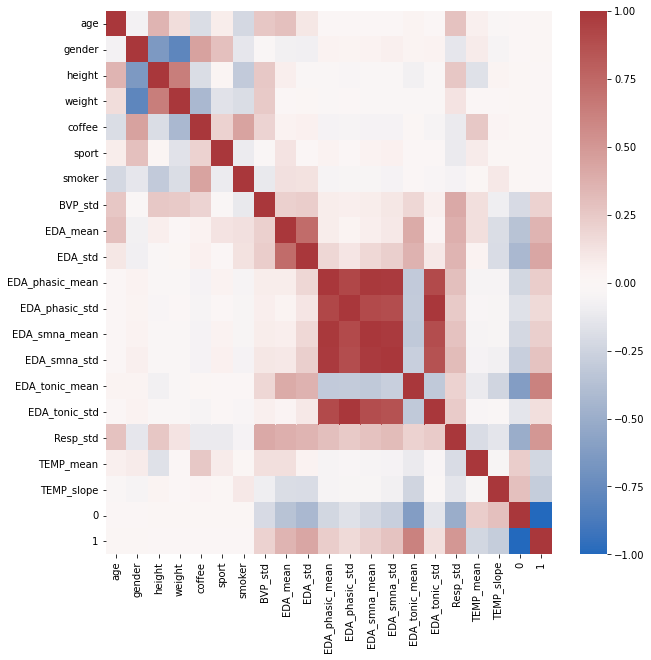

In [17]:
df_corr = pd.concat([df_may.drop('label', axis=1), pd.get_dummies(df_may['label'])], axis=1)
df_corr = df_corr.drop('subject', axis =1 )
corr = df_corr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="vlag")

The heatmap above presents the correlations between the different attributes.

The last 2 entries, 0 and 1, represent the stress label, with 0 being no stress and 1 being stress.

By looking at the overall correlation, the following general observations can be made:
- weight and height show rather strong positive correlations. This makes sense because taller people are in general also heavier.
- weight and height are negatively correlated with gender (male = 0, female = 1). This makes sense, because females are on average shorter than males. Additionally, like stated before, weight and height are positively correlated so it makes sense that when females are shorter than males, they will on average also weigh less.
- the entries in which people indicated to have no stress (0) show a negative correlation with EDA_tonic_mean, EDA_std and Resp_std and no correlation with gender 
- the entries in which people indicated to have stress (1) show a positive correlation with EDA_tonic_mean, EDA_std and Resp_std and no correlation with gender 
- EDA columns show strong positive correlations, except for EDA_tonic_mean, which shows a negative correlation with the other EDA columns
- Respatory data is somewhat positively correlated with EDA data
- BVP_std is somewhat positively correlated with height and weight
- Coffee attribute shows a positive correlation with TEMP_mean and with smoker

Now let's look more specifically the two sensitive attributes of age (groups) and gender and if they infer with the other attributes or not. 

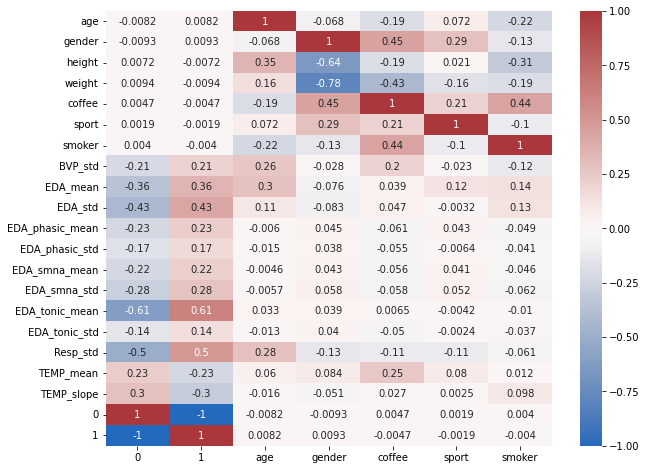

In [18]:
feats = df_may.columns[1:]
df_corr = pd.concat([df_may[feats].drop('label', axis=1), pd.get_dummies(df_may[feats]['label'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0,1, 'age', 'gender', 'coffee', 'sport', 'smoker']], annot=True, cmap="vlag")

Taking a closer look at experienced feelings of stress and gender, we see that the group that did not experience a feeling of stress shows a negative correlation with the EDA attributes and RESP_std. Additionally, they show a positive correlation with the temperature attributes. 

Another observation made is that the group of people that did experience feelings of stress shows a positive correlation with `EDA_tonic_mean`, `EDA_mean`, `EDA_std`, `Resp_std`. In general, the group that did experience stress and the group that did not experience stress show opposite correlations.

We also observe that gender is negatively correlated with the height and weight which means that when `gender` increases (from 0 to 1) the `height` and `weight` of the subject decreases and vice versa. We assume due to that female is indicated by 1 and that woman are in general smaller and weigh less compared to men. But, this is of course quite a bias. Therefore, we predict that `height` & `weight` should not be taken into account in the final analysis.

A few other observations are that the female gender shows a positive relationship with drinking coffee and sports and that smokers drink more coffee/coffee drinkers smoke more. Apart from this, gender shows solely weak correlations with the other attributes. Therefore, we assume for now that the sensitive attribute gender has no significant impact on the values of the measuring attributes.

# 2. Stress model development 

Now we start with developing the decision tree models. We base the models on the configurations that were indicated in the case.

While developing the models, we continuously reflect on the scores that the different models provide.

Let's start by importing the libs and helper functions.



In [19]:
# libraries for models
from sklearn.tree import DecisionTreeClassifier,plot_tree

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, r2_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [20]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

## 2.1 Splitting the data
With the required libs and helper functions imported we can start by splitting our data into train, test and classification sets. The following three variables are splitted:
- `X` i.e. the independent variables 
- `y` i.e. the dependent variables
- `A` i.e. sensitive variables / attributes 

Each of these variables data will be splitted into an test set of 33% and an train set of 67%. 

We start with an aware model, leaving all the sensitive attributes included.

In [21]:
# simple model - aware (incl. proxies)
# set test & train data & defining age as sensitive attribute
# unaware: X = df.drop(columns=['gender', 'age', 'label'])

X = df_may.drop(columns=['label'])
y = df_may['label']

A = df_may[['age', 'gender']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE, GENDER
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.33, 
    random_state=42)

## 2.2 Decision tree parameters
Now with the training and test data ready, the four decision trees are defined having the different depths and max possible leafs. These hyperparameters are used to regulate the decision trees and are explained below.   

### `max_depth`
The `max_depth` is an integer value that indicates the limit of splitting the tree into more nodes during the building of the decision tree, meaning the higher the `max_depth` of an tree the more complex it will be, resulting in that the training error will decrease, but at an certain depth the accuracy of the test data will drastically decrease due to overfitting.   

### `max_leaf_nodes`
The number of `max_leaf_nodes` are the total number of terminal nodes (leaves/end nodes) in a tree. For example an `max_leaf_nodes=2` means having two end nodes and therefore two possible outcomes/decisions. Having an high number of leaf nodes will result in an overly complex model, while having not enough leaf nodes will result in that the model won't be able to "capture" all the possible outcomes based on the data. 
 


## 2.3 Setting up the model + performance
With this small explanation in mind let's create a list with four different decision tree classification models having different `max_depth` and `max_leaf_nodes` hyperparameters. 

Based on the case we are restricted in using an `max_depth` and the `max_leaf_nodes` the following range of parameter values are allowed:
- `max_depth` : 3, 4, 5
- `max_leaf_nodes` : between 3 to 10
- `min_samples_leaf = 1`

In [22]:
# set up model:
classifiers = [
    DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, min_samples_leaf=1),
    DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6, min_samples_leaf=1),
    DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8, min_samples_leaf=1),
    DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, min_samples_leaf=1),
]

After setting up the four models, we predict a first initial decision within the observations of the train data based on the test data on whether a subject feels stressed or not. By taking a first look at the results we may observe similar results, which would indicate that all four models are performing equally, but to be sure we have to validate the performance of each decision tree. A good way of doing this is by using cross validation in order to determine the accuracy on different splits on the data. 

In [23]:
# train model, get accuracies and CV
groups_train = X_train['subject']
groups_test = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  scores_train = cross_val_score(model, X_train, y_train, cv=gkf, groups=groups_train, scoring='accuracy')
  scores_test = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups_test, scoring='accuracy')
  print (f'{model}  {chr(10)} CV train: {scores_train.mean()} {chr(10)} CV test: {scores_test.mean()} {chr(10)}')
  

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)  
 CV train: 0.8078749497697135 
 CV test: 0.7810263672982085 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)  
 CV train: 0.8176413596179407 
 CV test: 0.7974404960359043 

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)  
 CV train: 0.8150264868164817 
 CV test: 0.7739594501677962 

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)  
 CV train: 0.7963345414361225 
 CV test: 0.7854202895155642 



GroupKfold is trained on subject, because for each subject there are multiple observations (around 66 each).

The results are the mean value of 4 different data splits using the performance indicator accuracy. As we can observe the cross validation score of all four decision trees are quite simulair between 80 and 84 percent accuracy. But accuracy has the tendency to masks the issue of class imbalance and therefore we have to take other performance measures into account. 

In [24]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_train_pred_prob = model.predict_proba(X_train)[:,1] 
  y_test_pred_prob = model.predict_proba(X_test)[:,1] 
  roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
  roc_auc_test = roc_auc_score(y_test, y_test_pred_prob)

  print(f'{model} {chr(10)} ROC_AUC train: {roc_auc_train} {chr(10)} ROC_AUC test: {roc_auc_test} {chr(10)}')

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) 
 ROC_AUC train: 0.8813059317335868 
 ROC_AUC test: 0.8403847773006651 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6) 
 ROC_AUC train: 0.9685742852617407 
 ROC_AUC test: 0.9480508545929106 

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8) 
 ROC_AUC train: 0.97732042448721 
 ROC_AUC test: 0.9597541466700346 

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10) 
 ROC_AUC train: 0.9803298487368338 
 ROC_AUC test: 0.9568072745642839 



Here the models differentiate a bit more from each other. Based on the AUC score the Decision Tree model with not many leafs and a shallow depth performs worse than a decision tree model having many leaf nodes and the max depth of 5. 

Focussing on the ROC AUC which shows how well the model is able to distinguish between the positive and negative classes indicates that when the max_depth and max_leaf_nodes increase the model improves in determining these classes. 

We now observe that model 3 scores better than model 2, while this was the opposite in the previous analysis. However, model 2 - 4 show very similar results.

But ROC-AUC has an big disadvantage that is that is very sensitive towards class inbalance. As we have an very inbalance dataset, we have to make an False Negative, False Postive, True Negative, True postive analysis next. We will use an confusion matrix for this. 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

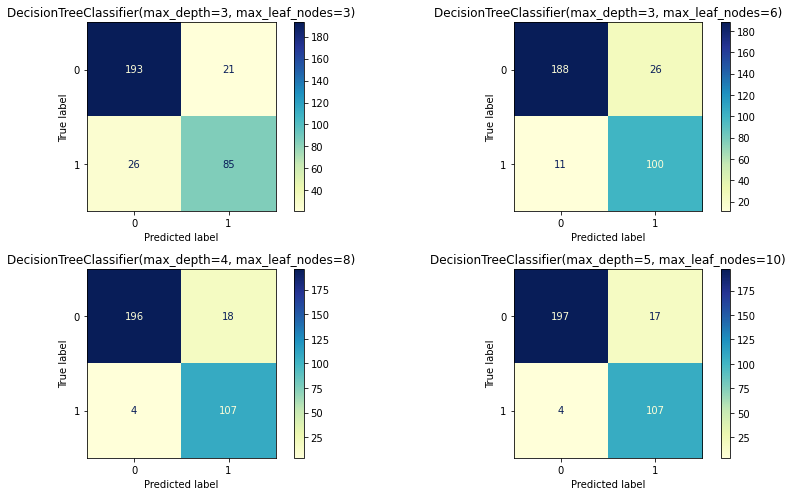

In [25]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(cls)
plt.tight_layout()
plt.show()

We will first also check the train set before we draw any conclusions.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

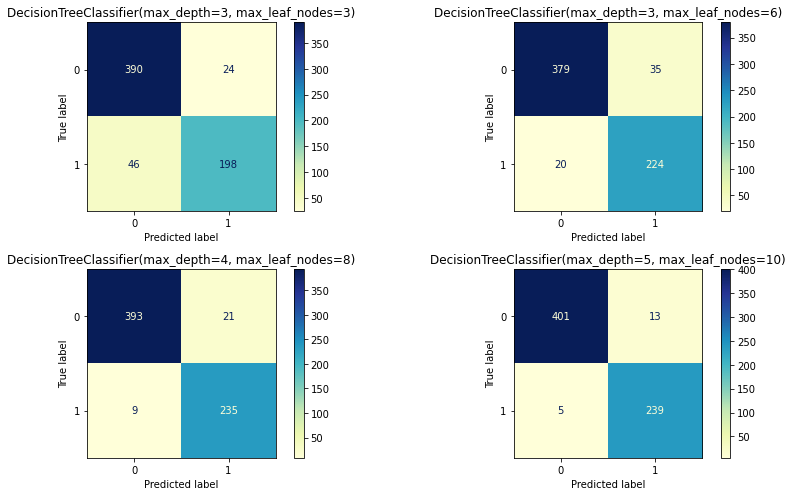

In [26]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(cls)
plt.tight_layout()
plt.show()

We see that all four model have high correct prediction rates. In the test set, the first model is not that strong, predicting about 1 out of 5 cases of stress wrongly. However, we see in the test data that there is almost no increase in accuracy between model 3 and 4. We see quite a large improvement in correctly predicting stress (false negative rate drops when the decision tree has more depth). We see a similar development in the train data with the false negative rate dropping when the depth of the model increases. The false positive rate is a bit more divided, with first showing a decreasing accuracy rate and only showing real improvement in the fourth model.

We see the following results on the different models:
- Accuracy: Model 2 shows the highest accuracy rate amongst test and train data.
- ROC_AUC: Model 3 and model 4 show the highest (and very similar) results based on this classification.
- Confusion matrix: Model 4 shows the highest results on both test and train data.

## 2.4 Classification report on the model
The classification report used in this case has four  performance measurements to test the models. These are:
- Precision 
- Recall
- f1-score
- support

### Precision
The precision performance measurements returns the precise/accuracy score of the model or in other words the percentage of correct positive predictions relative to total positive predictions. For this the following formula is used:

$$\text{$\dfrac{True Positive}{True positive+False Positive}, \:$ where the denominator is the Total Predicted Positives }$$

Percision is a good measure to determine, when the costs of False Positives is high. As we use classifiers we like to know the costs of False Positives counts.

### Recall
The recall metrics calculates how many of the actual positives the model captures (True Positives) using the following formula:

$$\text{$\dfrac{True Positive}{True positive+False Negative}, \:$ where the denominator is the Total Actual Positives }$$

### F1 score
The F1 score is an function of the Precision and Recall thereby seeking a balance between Precision and Recall.

F1 = 2 * $\dfrac{Precision+Recall}{Precision+Recall}\$

The F1 is mainly used as metric when there is an uneven class distribution 

### Support 
Simply tells us how many observations fit the two different classifications `stress` and `no stress`. 

In [27]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  target_names = ['no stress', 'stress']
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred, target_names=target_names)}')

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
               precision    recall  f1-score   support

   no stress       0.88      0.90      0.89       214
      stress       0.80      0.77      0.78       111

    accuracy                           0.86       325
   macro avg       0.84      0.83      0.84       325
weighted avg       0.85      0.86      0.85       325

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
               precision    recall  f1-score   support

   no stress       0.94      0.88      0.91       214
      stress       0.79      0.90      0.84       111

    accuracy                           0.89       325
   macro avg       0.87      0.89      0.88       325
weighted avg       0.89      0.89      0.89       325

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
               precision    recall  f1-score   support

   no stress       0.98      0.92      0.95       214
      stress       0.86      0.96      0.91       111

    accurac

Based on the four different decision trees, a classification report was created per decision tree model. 

Starting with precision metrics we see that the models percentage of correct positive predictions relative to total positive predictions increases for both stress and no stress classification groups when the `max_depth` and `max_leaf_nodes` increases. Which is in this case logical because the deeper the tree model means that more possible decisions can be checked. 

Looking at the recall we observe a big jump in accuracy for the classification group `stress` when the `max_leaf_nodes` parameter doubles from `3` to `6` leaving the `max_depth = 3`. Meaning that when the number of end nodes increase the model can better predict `stress`. This can be due to the inbalance between `no stress` and `stress` observations. 

Combining the `precision` and `recall` and taking the average using `f1 score` metric we can clearly see that the prediction quality of the model is increasing when the `max_depth` and `max_leaf_nodes` increase for both classification groups. However, the score doesn't increase in quality much between the third and fourth model.

Looking deeper into the differences we find the trade-off between the precision and the recall using the precision recall curve. 


### Precision recall curve
As the data is unequally distributed between `stress` and `no stress` observations the precision recall curve can be used to determine the prediction skill of the model by plotting the results of the `precision` on the y-axis and the `recall` on the x-axis per theshold. By doing this we observe the classification reports results using plots in which the skill of the model is depicted by (1,1) meaning that the model is perfect for this dataset.

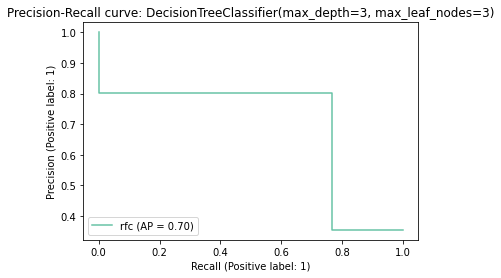

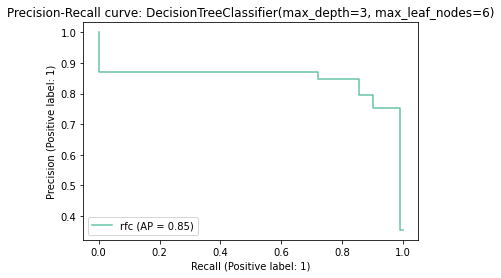

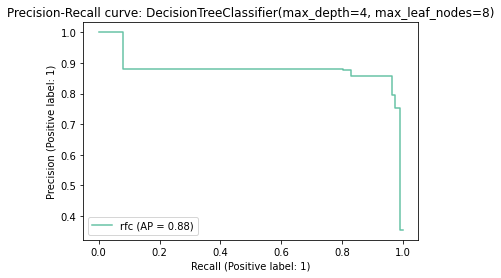

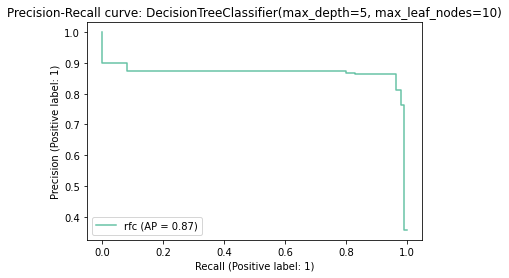

In [28]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

Based on the four plots we can observe when the `max_depth` amd `max_leaf_nodes` increase the plot edge closer to (1,1) on both axises. We observe that when the `max_depth = 3` and `max_leaf_nodes = 3` the prediction skill of the model is quite bad. But when these parameter values increase the curve becomes more and more visible (moving to 1,1). Next to this, we see that there is not much more increase in performance comparing  model 3 `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and model 4 `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` meaning that based on these graphs the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` is the best canditate for the model.   

## 2.5 Interim conclusion 
Based on the different metrics, findings and interpretations we can make the following conclusions:
- Based on the `accuracy` and `ROC_AUC` scores the best model for this dataset is `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`
- Based on the confusion matrix `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` shows the highest results on both test and train data.
- Based on the `precision`, `recall` and `F1` metrics both `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` are the best canditates for the model. 
- Based on the `Precision recall curve` after `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` no further gains in improved predictions are made

Therefore, based on these findings we choose the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` as the best model for this dataset.  


# 3. Explainability of Decision Trees
As based on the performance metrics the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` is the best canditate for predicting the stress level. We dive deeper into this canditate (and the others) in order to offer an insight in how explainable these trees each are. In this chapter we will focus on the graphical structure of the trees and on whether these are interpretable or not, thereby specificly looking at: 

<ol type='a'>
  <li>Visualise the decision tree structure graphically and comment on how the decision tree
makes decisions and point to the visualisation providing examples.</li>
  <li>Produce text results to make the decision tree transparent. How many nodes each tree has? Which are the decision tree rules?</li>
</ol>

Let's start by visualising the our current chose decision tree model `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`. 


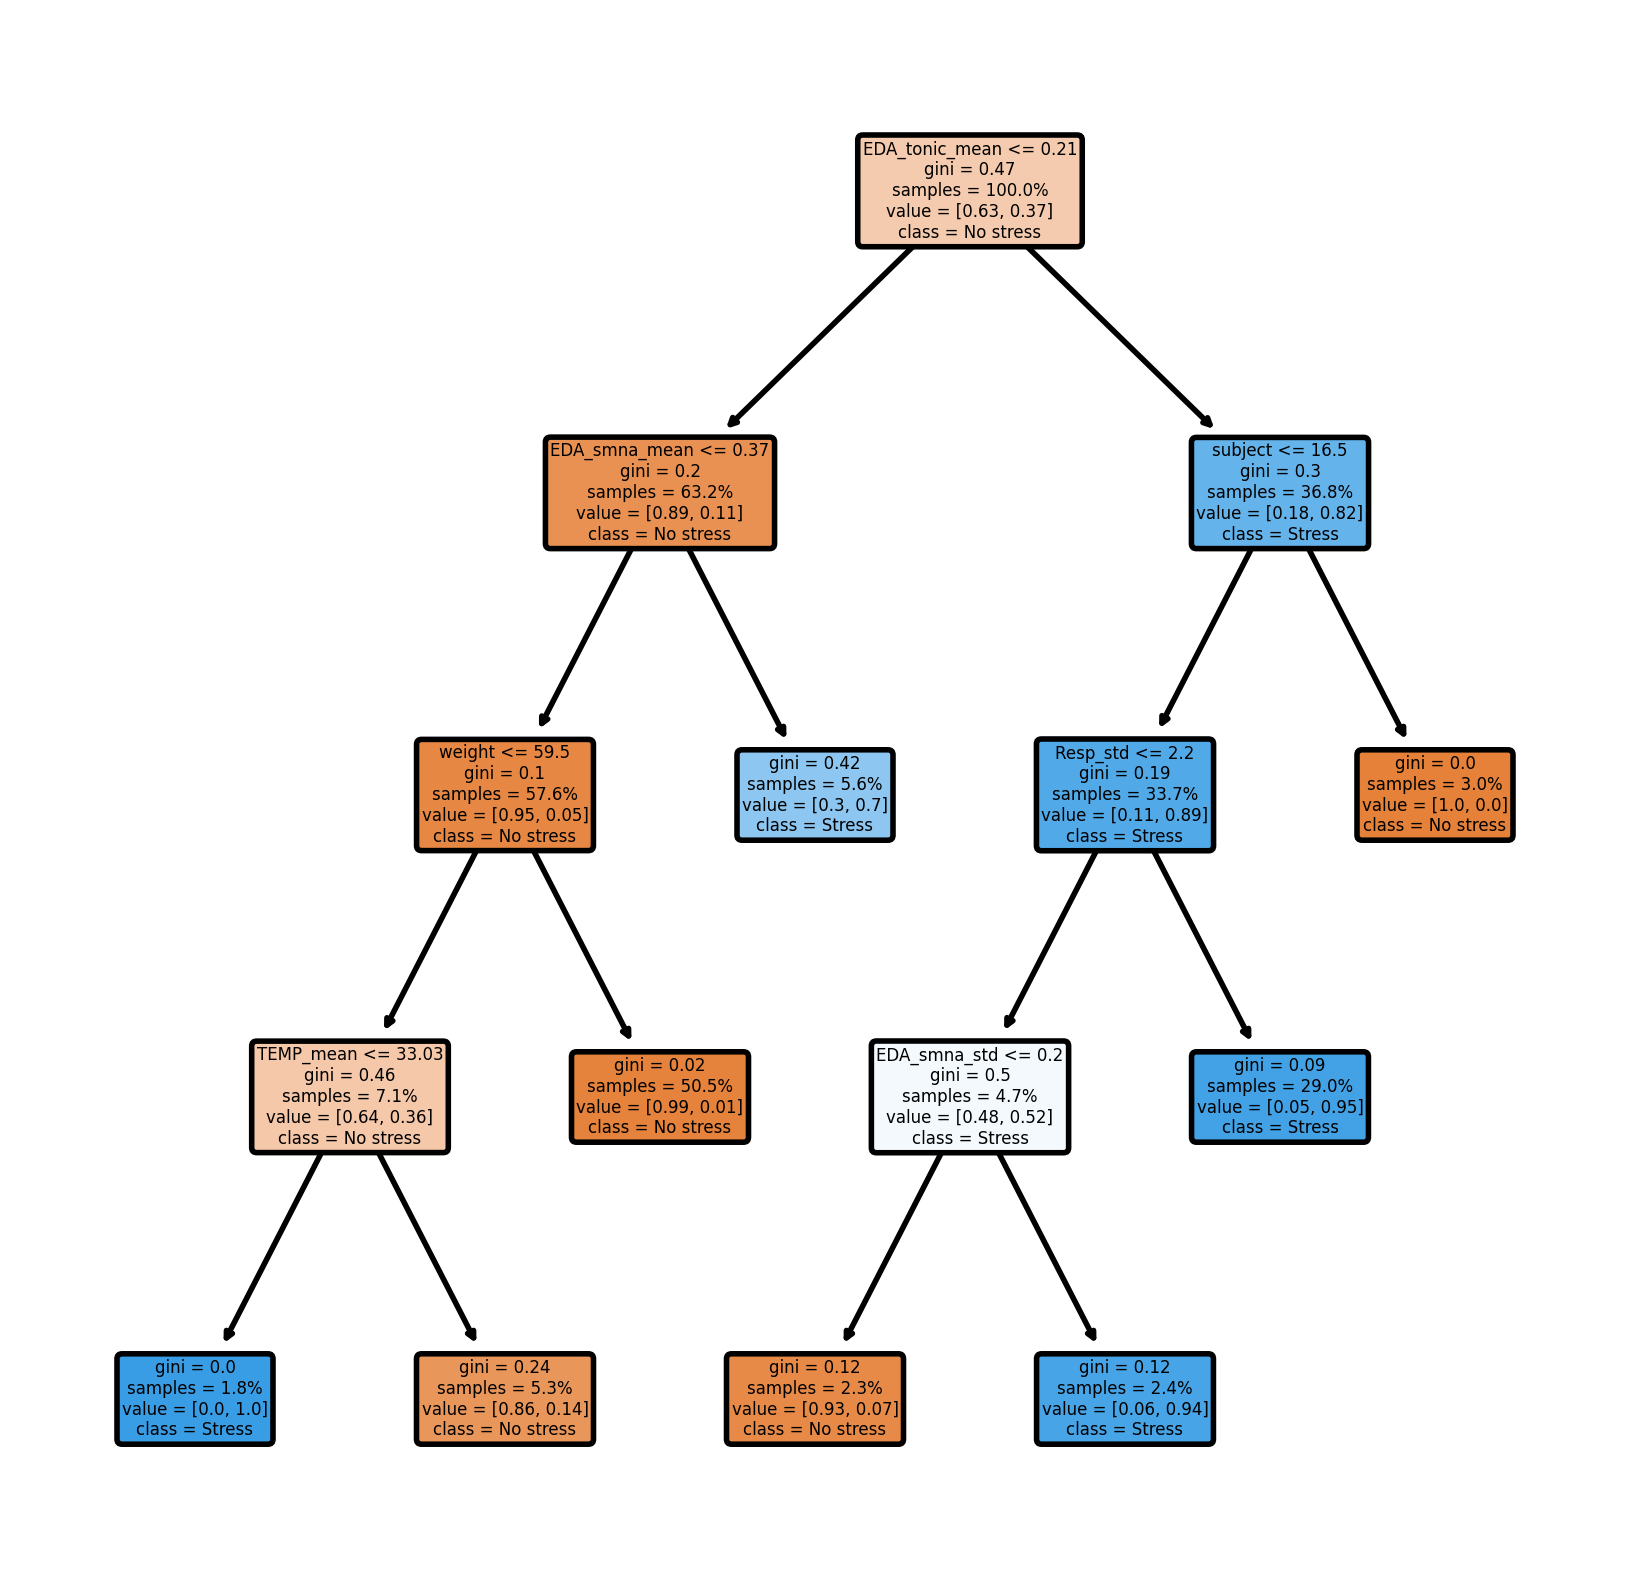

In [29]:
estimator = classifiers[2].fit(X_train,y_train)
plt.figure(dpi=400,edgecolor="r",figsize=(5,5))
F = X.columns
C=['No stress','Stress']
plot_tree(estimator, filled=True, feature_names=F, class_names=C, precision=2, proportion=True, rounded=True, fontsize=3)
plt.show()

Here we plotted an estimation results / decisions of the `x_train` and `y_train` data for the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` model. Let's start with an interpretation of the root node (upper/first node):
- **`EDA_tonic_mean <= 0.21`** is the question the tree ask itself meaning if the `EDA_tonic_mean` is smaller of equal to 0.21 then follow the `True path (go left)` and if not follow the `False path (go right)`.
- **`gini = 0.47`** the gini score quantifies the purity of the node. An gini score higher than zero implies that the node has samples that belong to multiple classes (i.e. no stress or stress)
- **`samples = 100%`** indicates total samples (in %) in the node, where the root node always starts with all samples, hence 100%. 
- **`value = [0.63, 0.37]`** indicates (in %) how many samples fall in each class, meaning that 63% of the samples feels no stress and 37% feels stress. 
- **`class = No stress`** the class value (= no stress) is the decision that this node makes based on the highest `value` (= 0.63) attribute.

In this tree, there are four possible outcomes that indicate stress, this includes 5,6 + 29,0 + 1,8 + 2,4 = 38,8 percent of the outcomes. 

Each time, the tree makes a decision on whether a value is higher or lower than a certain amount, which helps the model to indicate whether there are signs that point towards the subject having stress/no stress. Based on the answers on the different indicators, the model determines whether there is stress or no stress predicted.

The other three decision trees can also be plotted using a loop having the same implementation and interpretation as our chose tree.  


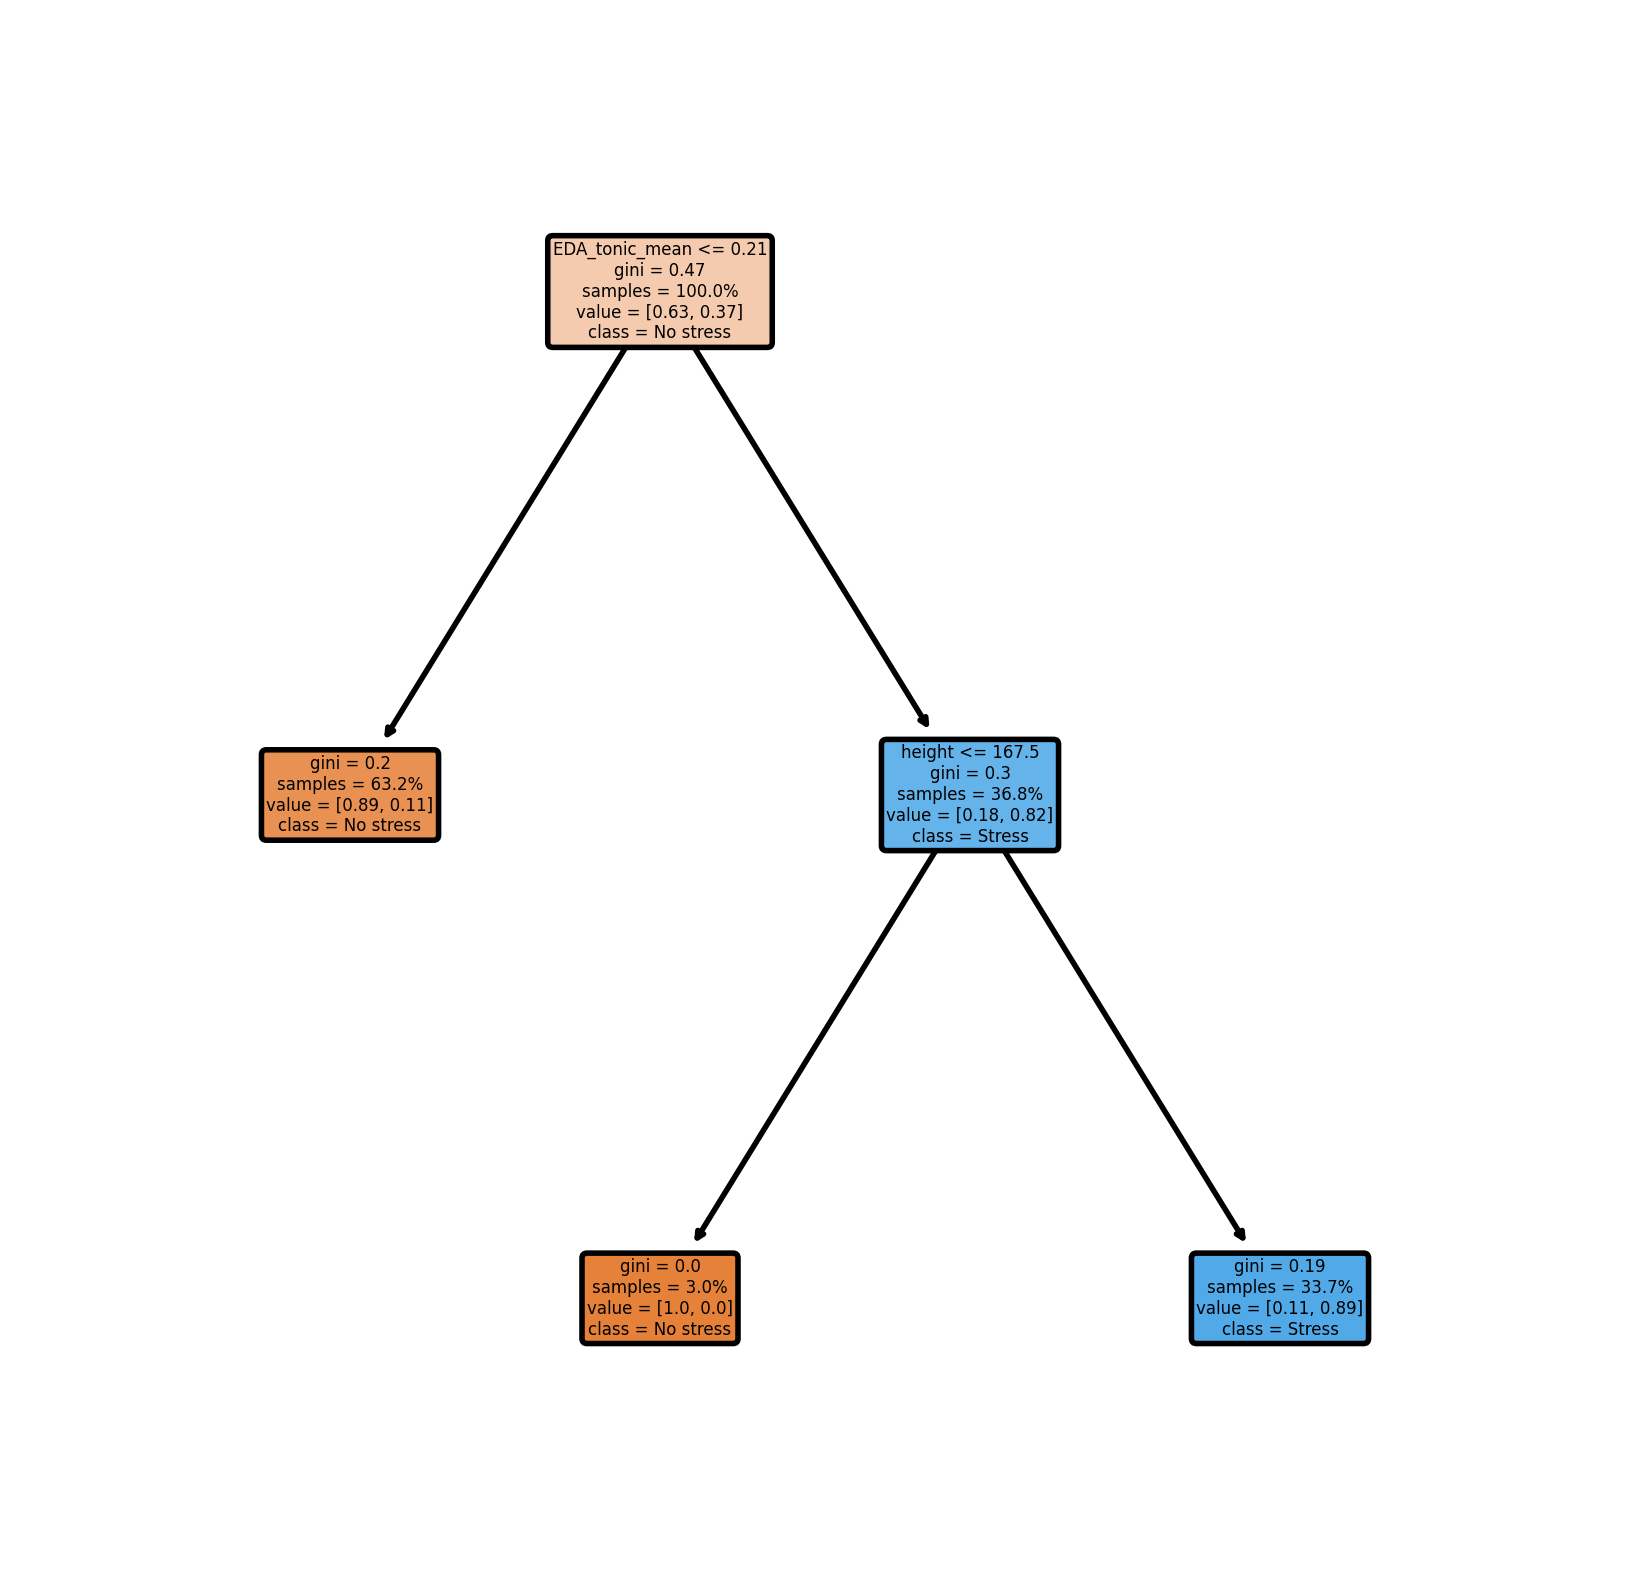

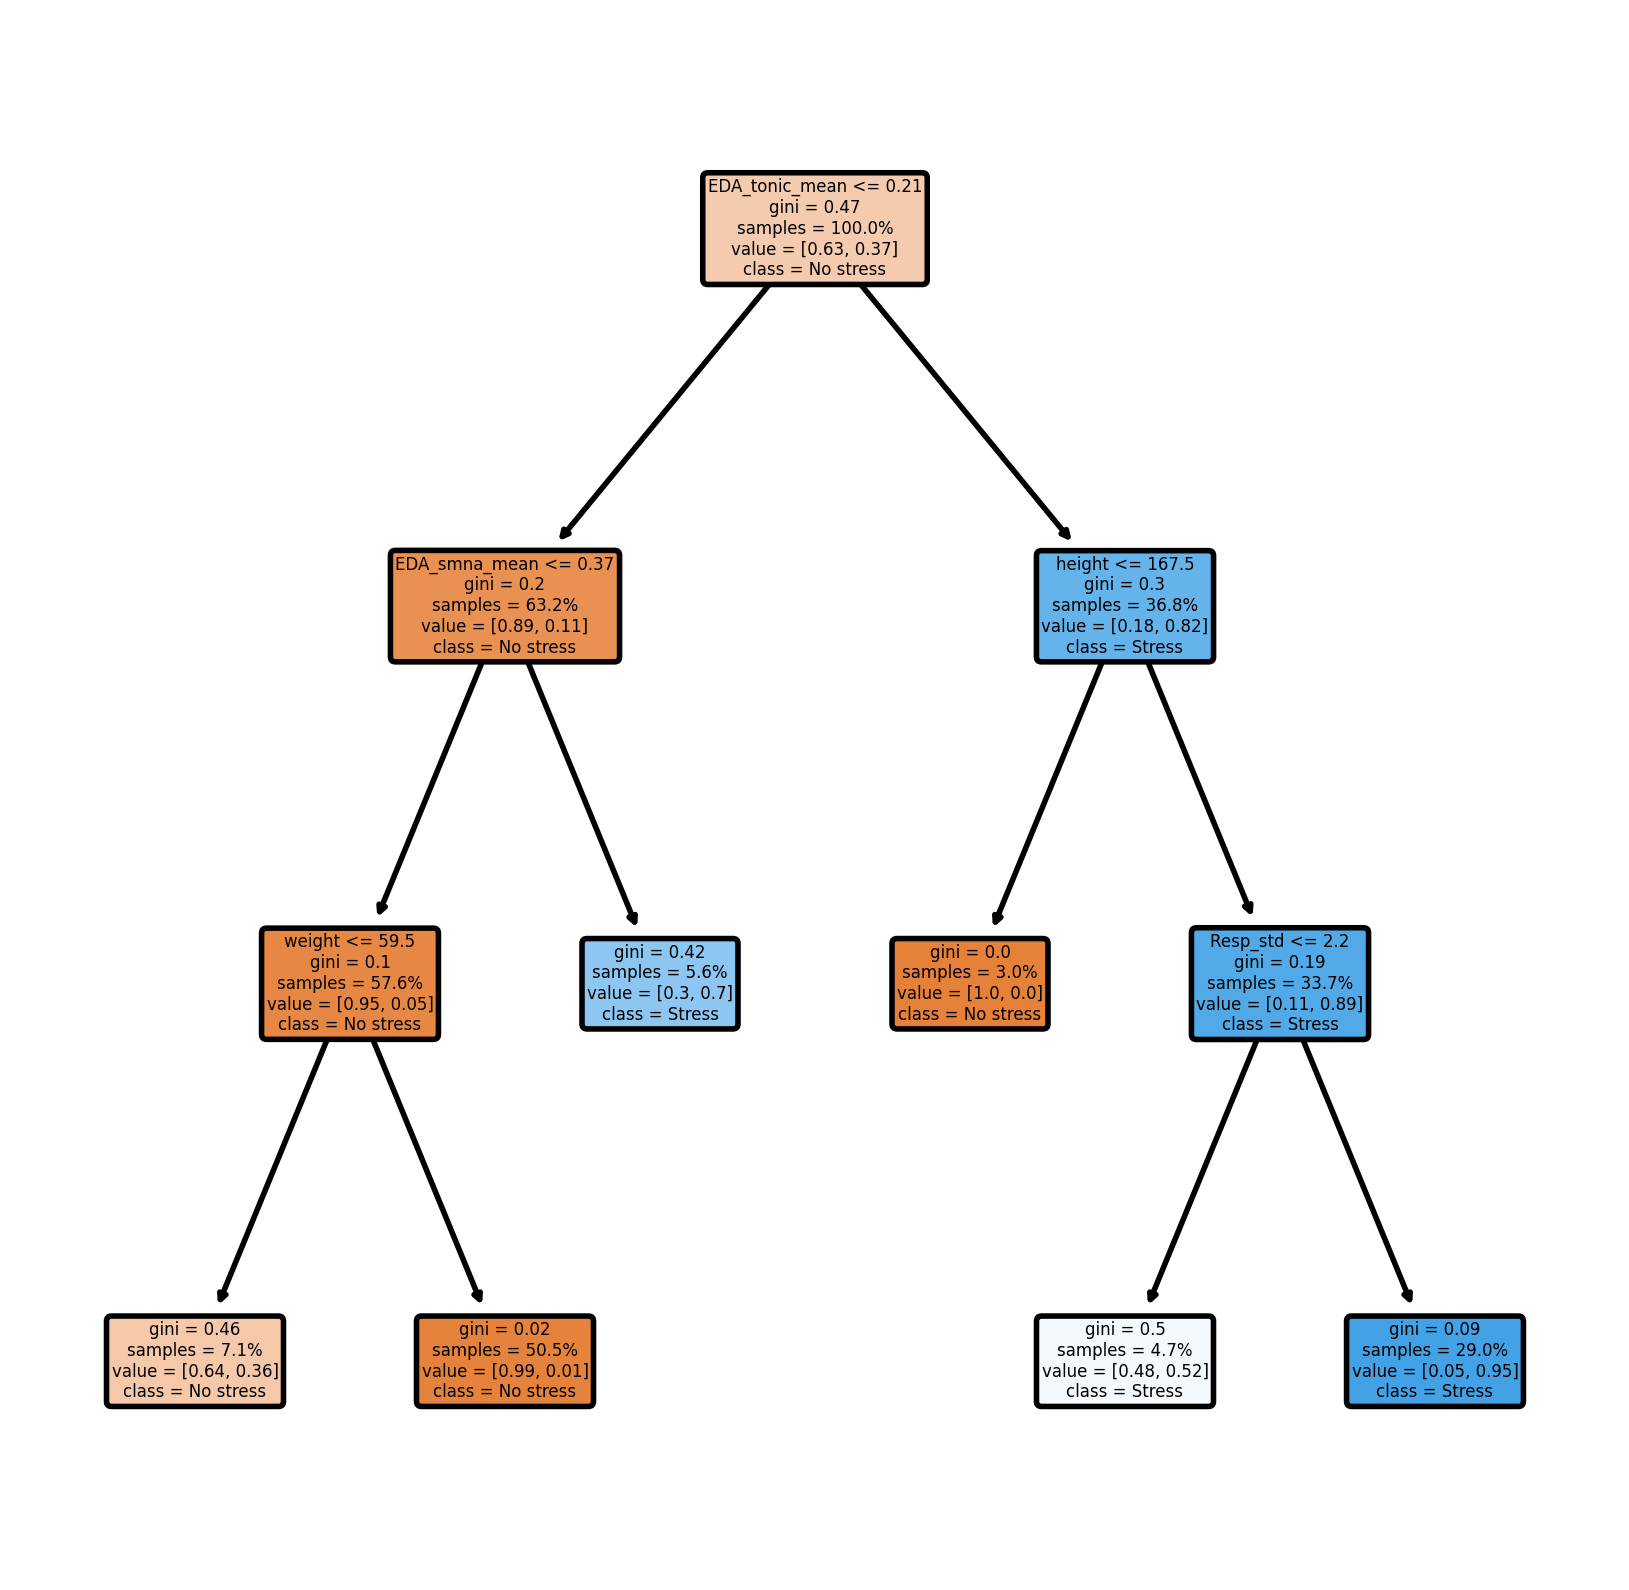

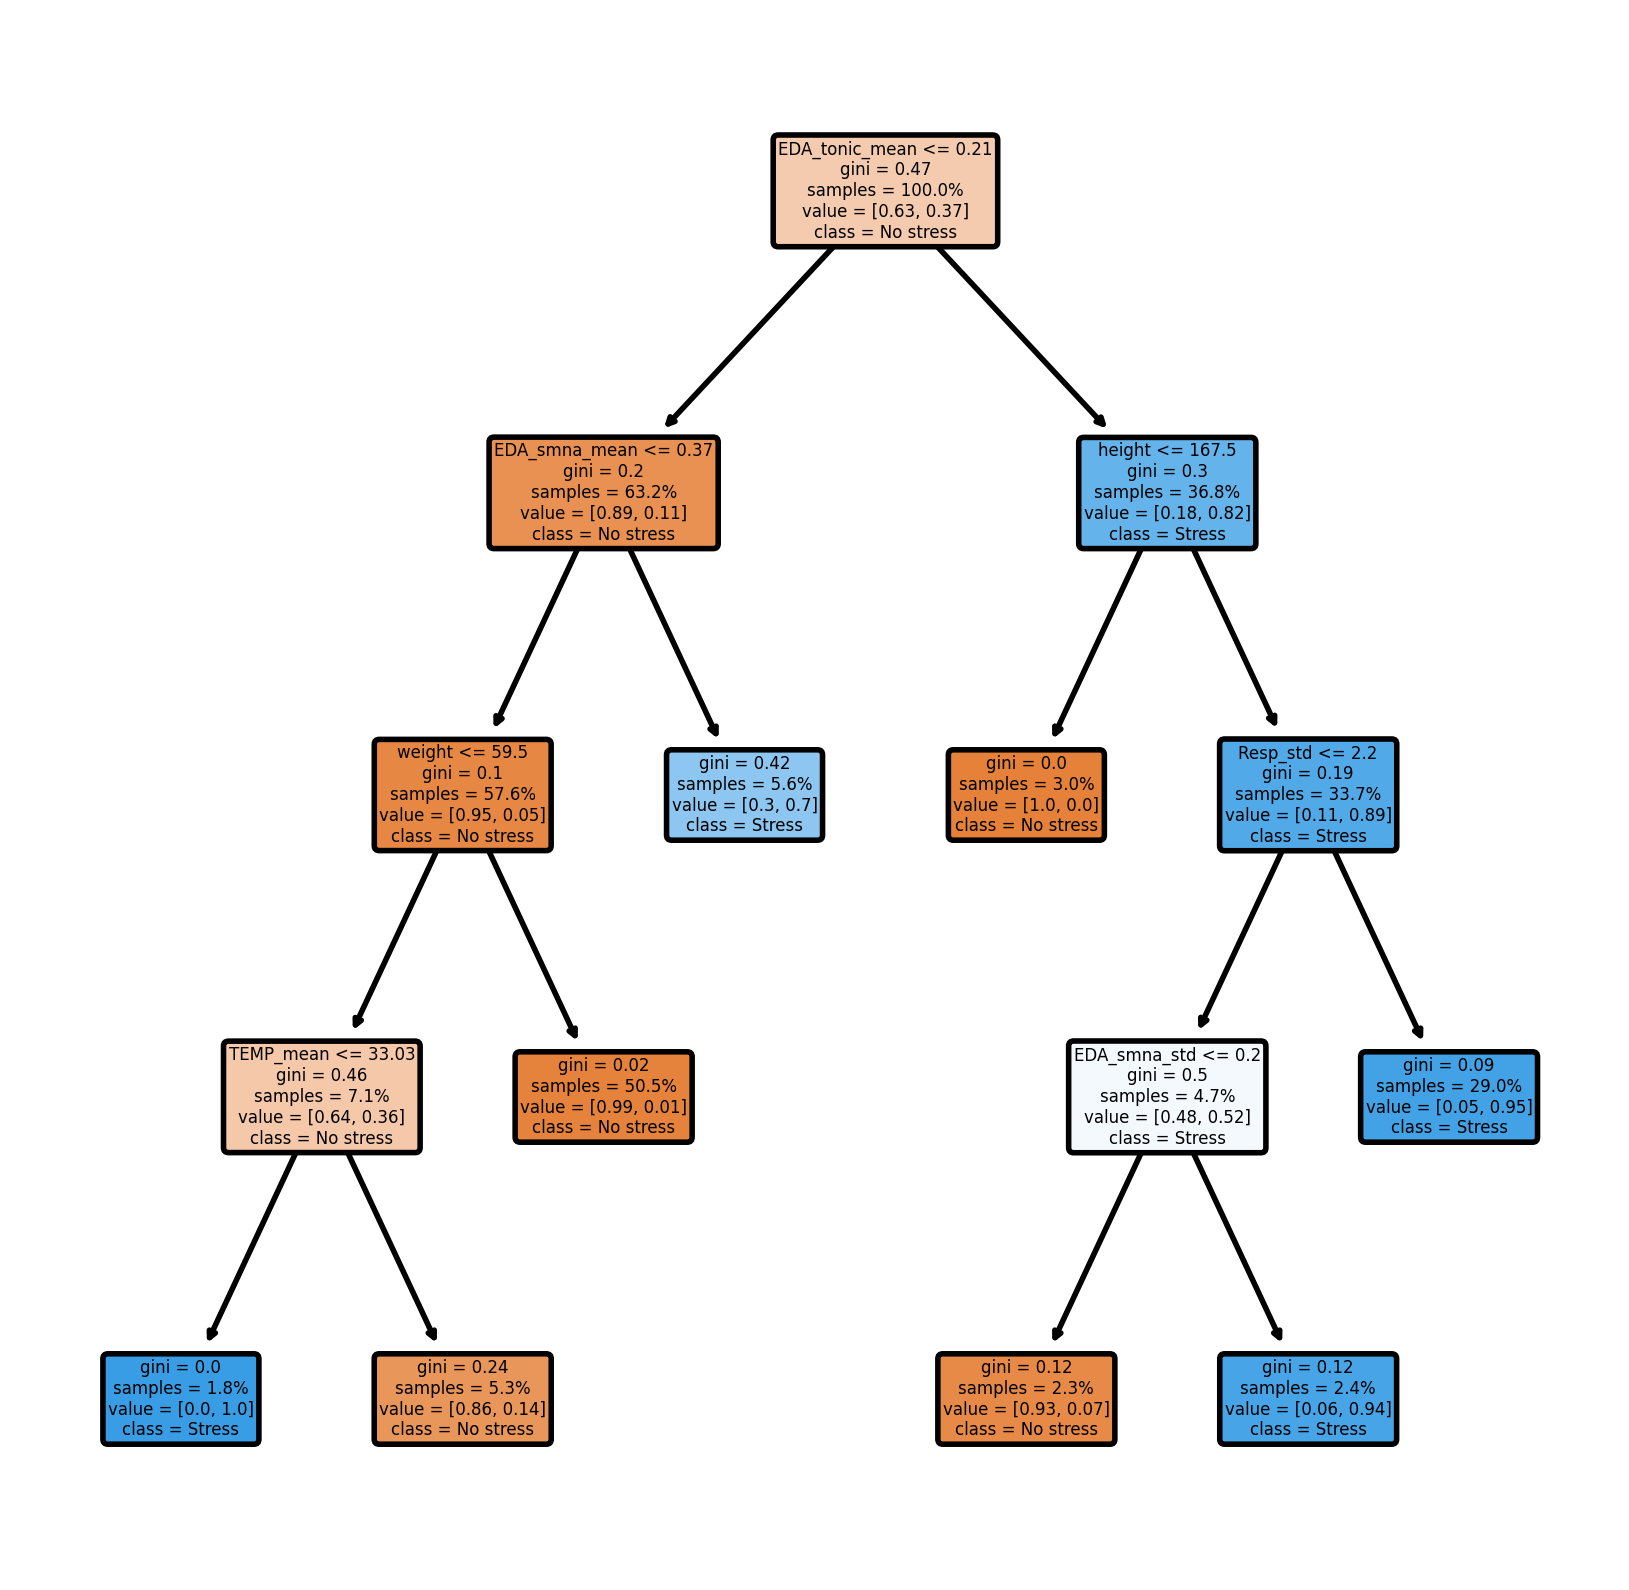

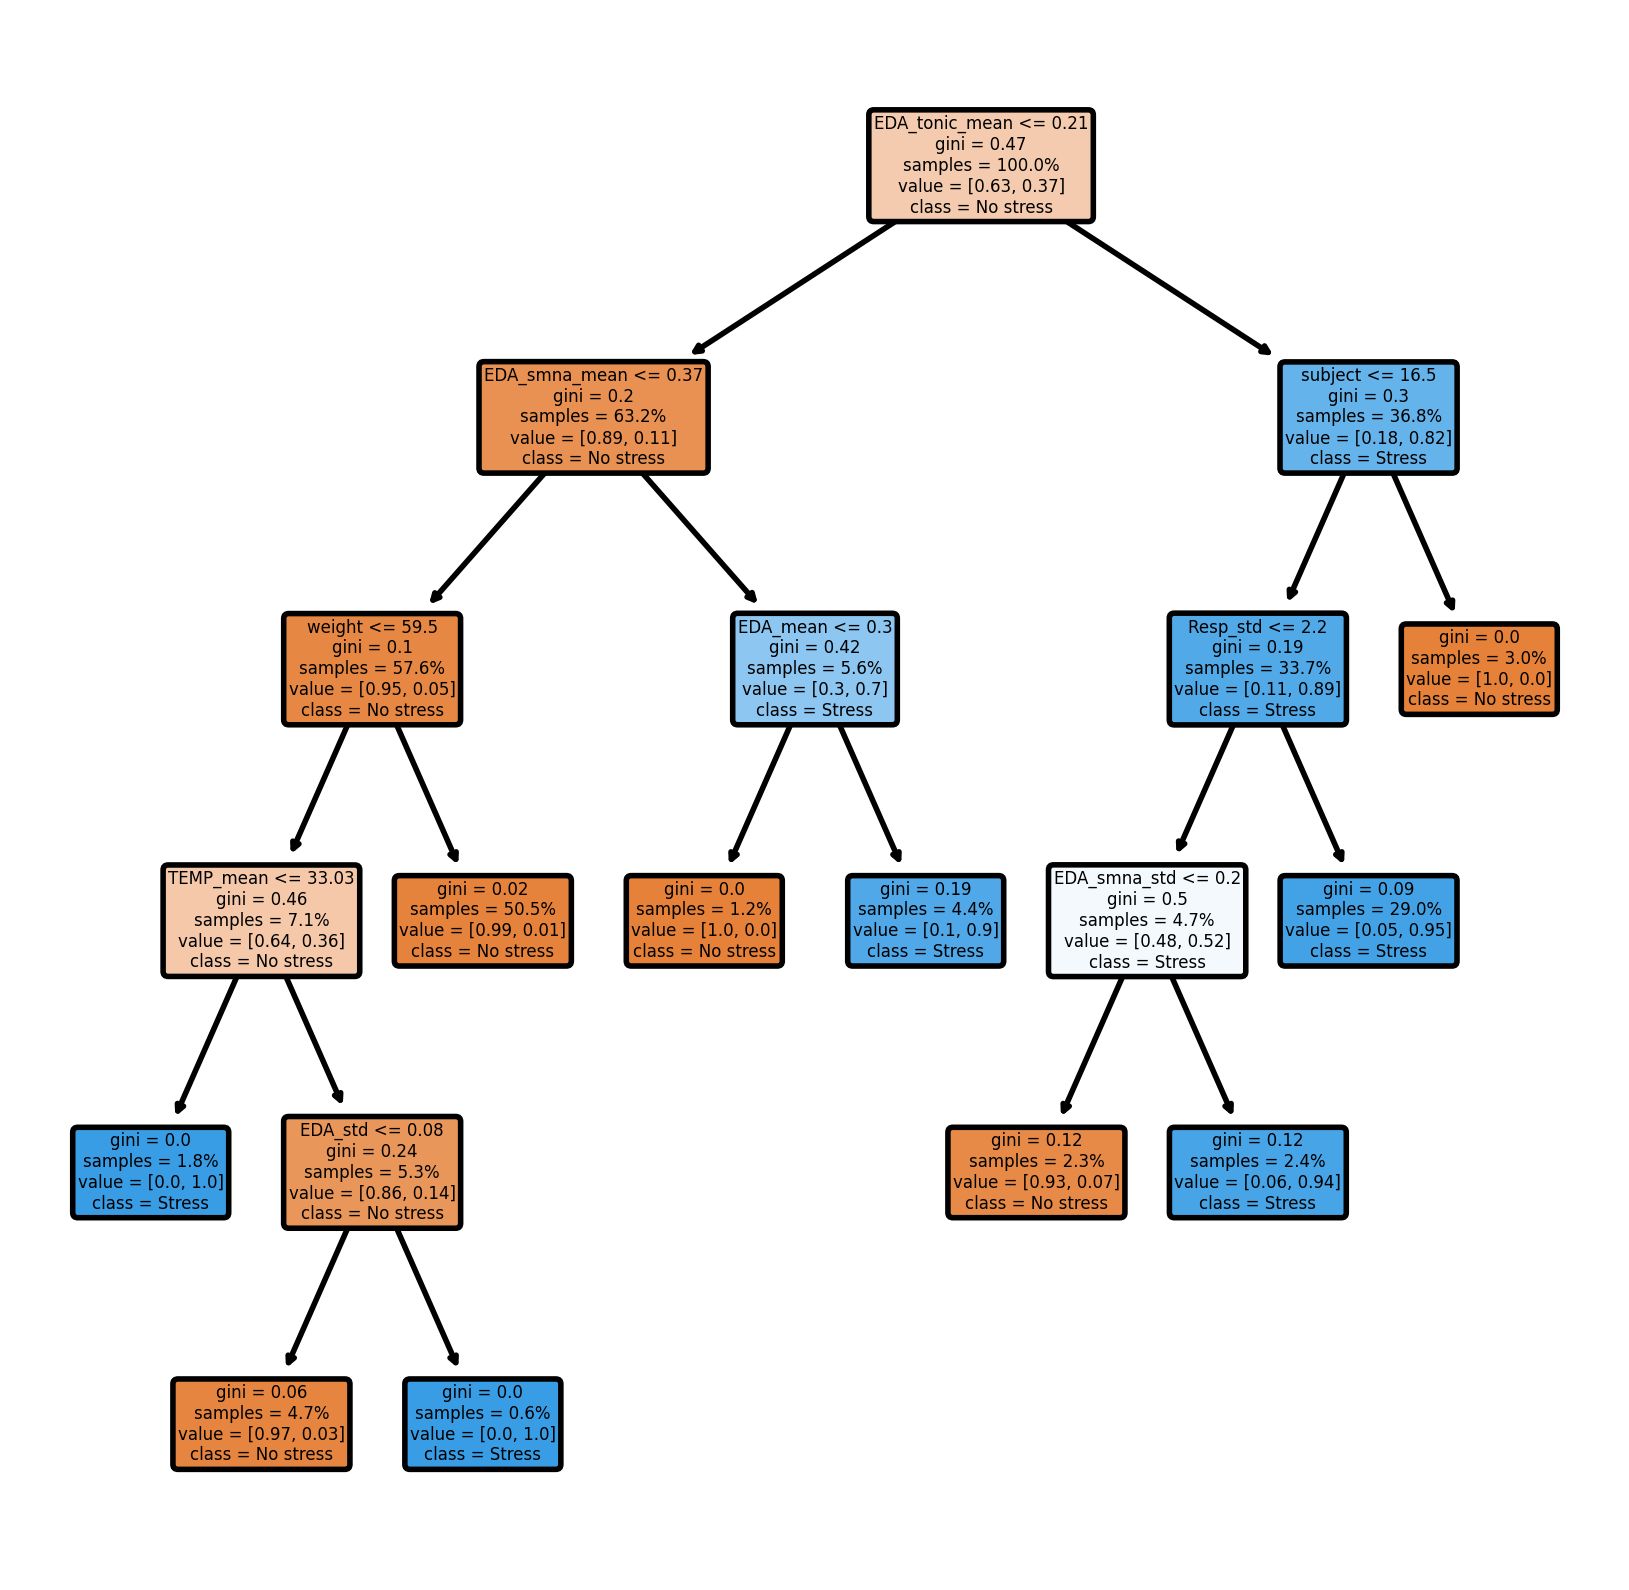

In [30]:
for model in classifiers:
  estimator = model.fit(X_train,y_train)
  plt.figure(dpi=400,edgecolor="r",figsize=(5,5))
  F = X.columns
  C=['No stress','Stress']
  plot_tree(estimator, filled=True, feature_names=F, class_names=C, precision=2, proportion=True, rounded=True, fontsize=3)
  plt.show()


With all the trees plotted and our chosen tree explained. We can further define and explain the tree logic by making the tree more transparent. We will do this in the next step. 

## 3.1 Tree transparency
With the tree plotted and its choices and attributes from the nodes explained and interpreted, it's time to make `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` more transparent starting with textualising the possible decisions of each node.

In [31]:
estimator = classifiers[2].fit(X_train,y_train)

In [32]:
# count the number of nodes
n_nodes = estimator.tree_.node_count
# get the ID of the left child of a node
children_left = estimator.tree_.children_left
# get the ID of the right child of a node
children_right = estimator.tree_.children_right
# We can also view the feature (attribute) used to split the node into the left and right child nodes:
feature = estimator.tree_.feature
# A threshold attribute will show the value at the node:
threshold = estimator.tree_.threshold
# The above are useful for the Explainability of the Decision Tree

In [33]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # the seed is the root node id and its parent depth

In [34]:
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # Exploring the test mode
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

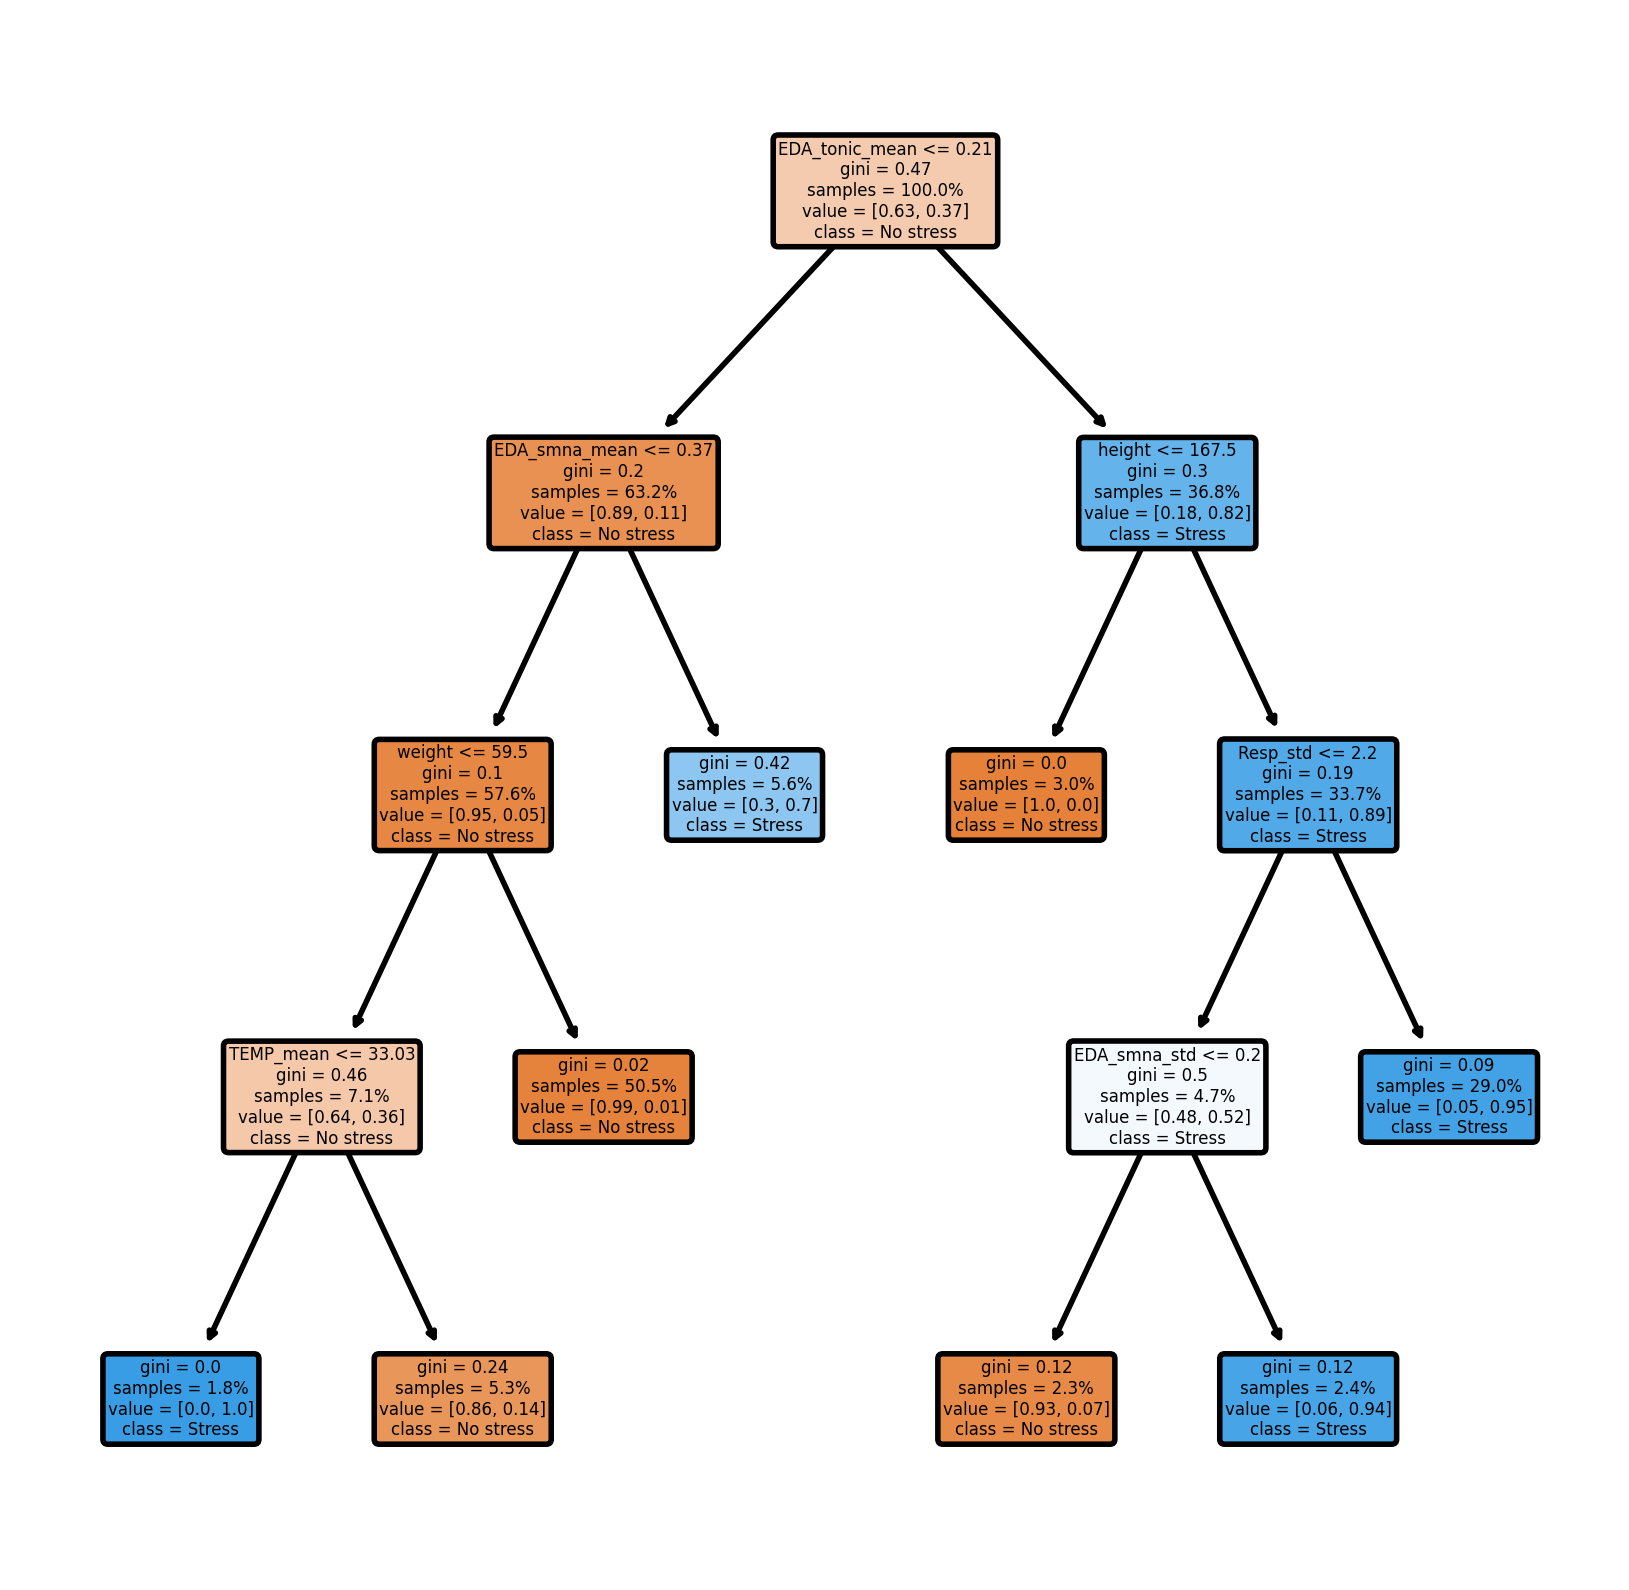

In [35]:
estimator = classifiers[2].fit(X_train,y_train)
plt.figure(dpi=400,edgecolor="r",figsize=(5,5))
F = X.columns
C=['No stress','Stress']
plot_tree(estimator, filled=True, feature_names=F, class_names=C, precision=2, proportion=True, rounded=True, fontsize=3)
plt.show()

### Number of nodes
Complexity means having less transpareny. One way of analysis the complexity of decision trees is to compare the number of nodes of each decision tree. 

In [36]:
for model in classifiers:
  n_nodes = model.tree_.node_count
  print(model, 'has', n_nodes, 'nodes')

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) has 5 nodes
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6) has 11 nodes
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8) has 15 nodes
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10) has 19 nodes


Based on this we can see that `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` has the most nodes (19), which means that based on this that `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` is the most complex tree and `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` having 5 nodes is the most simple one. 

As we indicated in earlier analysis the current best performing decision tree model is `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`, as can been seen by the number of nodes this is one of the models that can be quite complex to interpret. This can also be observed by looking at the decision rules of each tree model using the code below.  

In [37]:
for model in classifiers:
  estimator = model.fit(X_train,y_train)
  n_nodes = estimator.tree_.node_count
  children_left = estimator.tree_.children_left
  children_right = estimator.tree_.children_right
  feature = estimator.tree_.feature
  threshold = estimator.tree_.threshold
  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, -1)]  

  while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # Exploring the test mode
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

  print(f"\nThe {model} has %s nodes and has "
    "the following tree structure: \n"
    % n_nodes)
  for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print(f'%snode={i} test node: go to node {children_left[i]} if {X.columns[feature[i]]} <= {threshold[i]} else to node {children_right[i]}' % (node_depth[i] * "\t"))



The DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) has 5 nodes and has the following tree structure: 

node=0 test node: go to node 1 if EDA_tonic_mean <= 0.2084702029824257 else to node 2
	node=1 leaf node.
	node=2 test node: go to node 3 if subject <= 16.5 else to node 4
		node=3 leaf node.
		node=4 leaf node.

The DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6) has 11 nodes and has the following tree structure: 

node=0 test node: go to node 1 if EDA_tonic_mean <= 0.2084702029824257 else to node 2
	node=1 test node: go to node 5 if EDA_smna_mean <= 0.3701964318752289 else to node 6
	node=2 test node: go to node 3 if height <= 167.5 else to node 4
		node=3 leaf node.
		node=4 test node: go to node 9 if Resp_std <= 2.2024662494659424 else to node 10
		node=5 test node: go to node 7 if weight <= 59.5 else to node 8
		node=6 leaf node.
			node=7 leaf node.
			node=8 leaf node.
			node=9 leaf node.
			node=10 leaf node.

The DecisionTreeClassifier(max_depth=4, max_leaf_node

Based on the results the decision tree rules per tree are as follows:

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)`

- If EDA_tonic_mean <= 0.2084702029824257 then the tree will predict the class of the leaf node 1.
- Else, if subject <= 16.5 then the tree will predict the class of the leaf node 3.
- Else, the tree will predict the class of the leaf node 4.

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`:

- If EDA_tonic_mean <= 0.2084702029824257, the tree goes to node 1.
- If EDA_smna_mean <= 0.3701964318752289, the tree goes to node 5.
- If height <= 167.5, the tree goes to node 3.
- If Resp_std <= 2.2024662494659424, the tree goes to node 9.
- If weight <= 59.5, the tree goes to node 7.

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`:

- If EDA_tonic_mean <= 0.2084702029824257, the tree goes to node 1.
- If EDA_smna_mean <= 0.3701964318752289, the tree goes to node 5.
- If height <= 167.5, the tree goes to node 3.
- If Resp_std <= 2.2024662494659424, the tree goes to node 11.
- If weight <= 59.5, the tree goes to node 7.
- If TEMP_mean <= 33.032033920288086, the tree goes to node 9.
- If EDA_smna_mean <= 0.0870700478553772, the tree goes to node 13.

`DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`:

- If EDA_tonic_mean <= 0.2084702029824257, the tree goes to node 1.
- If EDA_smna_mean <= 0.3701964318752289, the tree goes to node 5.
- If height <= 167.5, the tree goes to node 3.
- If Resp_std <= 2.2024662494659424, the tree goes to node 11.
- If weight <= 59.5, the tree goes to node 7.
- If TEMP_mean <= 33.032033920288086, the tree goes to node 9.
- If EDA_mean <= 0.2972116470336914, the tree goes to node 15.
- If EDA_std <= 0.0755641870200634, the tree goes to node 17.
- If EDA_smna_mean <= 0.0870700478553772, the tree goes to node 13

Based on these rules we can observe that the number of decision drastically increases. To many decision rules can cause overfitting of the model, which in our case could mean that the model has an more difficult time capturing unrepresented data and predictions like female stress or no stress or stress of people age 28 or above.

All in all it depends what the overall aim of the stress model is. If it is indended for predicting an accurate stress prediction then the decisions tree `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`is the better options. But else the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` could be another good option, sacrificing performance for improved transparency. 

# 4. Bias management
The next step is to perform a Bias Management analysis on the sensitive attributes `age` and `gender` for all 4 decision trees. 

<ol type='a'>
  <li>Insights regarding performance per sensitive category group</li>
  <li>Insights regarding performance using fairness metrics (equalised odds, demographic
parity difference, false negative rate difference). You can use visualisation aids to plot
disparities to support your arguments.</li>
  <li>
  Findings from de-biasing the 4 Decision Tree Models including:
  <ul >
    <li>Reweighting of samples</li>
    <li>Fairness evaluations according to the aforementioned fairness criteria</li>
    <li>Fairlearn postprocessing methods to report false positives / negatives per sensitive group</li>
    <li>Fairlearn postprocessing methods optimising the decision threshold per sensitive group  </li>
  </ul>
  </li>
</ol>

Let's start with gaining insight in the performance per sensitive group `age` and `gender` by determining the False Positive, False Negative, True Postive, and True Negative rates. 

## 4.1 Performance per sensitive category group
Calculate the metrics FPR, FNR, TPR and TNR for each model for `age` and `gender`.

In [38]:
# define sensitive attributes
age = A_test['age']
gender = A_test['gender']

for model in classifiers:
  model.fit(X_train, y_train)
  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]
  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1
  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame(age)} {chr(10)}')
  print(f'Gender:{chr(10)}{model}: {chr(10)} {metric_frame(gender)} {chr(10)}')
  print('--------------------------------------------------------------------')

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarn

Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
           FPR       FNR       TPR       TNR
age                                        
0    0.158333  0.161765  0.838235  0.841667
1    0.021277  0.348837  0.651163  0.978723 

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.084270  0.090909  0.909091  0.915730
1       0.166667  0.558824  0.441176  0.833333 

--------------------------------------------------------------------
Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
           FPR       FNR       TPR       TNR
age                                        
0    0.200000  0.044118  0.955882  0.800000
1    0.021277  0.186047  0.813953  0.978723 

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.112360  0.012987  0.987013 

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Gender:
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.067416  0.025974  0.974026  0.932584
1       0.138889  0.058824  0.941176  0.861111 

--------------------------------------------------------------------


The results indicate the performance rate in percentage of False Positives (FPR), False Negatives (FNR), True Positives (TPR) and True Negatives (TNR) per sensitive attribute per decision tree model in predicting stress or no stress. 

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)`
- `Age group under 27` : with an around 15-16% FPR and FNR the model has quite a large rate of incorrectly predicting if someone is stressed or not, But the TPR and TNR indicate quite a good score in correctly predicting stress 
- `Age group 28 or higher` : Has an very low FPR, but very high FNR, meaning that this for this age group is not making many FP predictions, but makes alot of FN predictions, meaning that the model incorrectly predicts that someone is not stressed, while he/she is. 
- `Gender 0 (male)` : this model has an very low FP/FN rate, while having an very high TPR/TNR, meaning that the model is very good in predicting stress for `male`. 
- `gender 1 (female)` : this model has an very high FNR (55%) meaning that the model incorrectly classifies no stress, while the female subject is stressed, this automatically means that the model has very low TPR (44%)   

The `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` is good for predicting stress for people that are under 27 years old and people that are male.

---

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`: 
- `Age group under 27` : the model has quite high FPR (20%) vs low FNR (4%), meaning that the model predicts for people under 27 years old stress, while it is not stress. The TPR/TNR are quite high, meaning that the model is quite good at predicting stress/no stress for people under 27 years old. 
- `Age group 28 or higher` : here it is vice versa, low FPR and high FNR meaning that the model predicts for people being 28 years old or higher no stress, while it should have been stress.  
- `Gender 0 (male)` : has an quite high FPR (11%) meaning the model predicts stress, while in reality the subject is not stressed 
- `gender 1 (female)` : high FPR (16%) and FNR (29%) meaning that the model predicts wrongly stress and no stress overall  

---

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`:
- `Age group under 27` : has quite an high (13%) FPR meaning that 13% of the cases the model predicts stress, while it should have been no stress. 
- `Age group 28 or higher` : very low FPR/FNR and TPR/TNR, having 100% perfect score on TPR. Hence, the model predicts almost perfectly stress for age group 28. 
- `Gender 0 (male)` : very low FPR/FNR and very high TPR/TNR meaning the model predicts stress very for males
- `Gender 1 (female)` : quite high FPR (11%) meaning that the model predicts stress incorrectly in 11% of the cases. 

The `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` is a good model to predict stress on people that are 28 years old or above and are male. The near perfect scores for age group 28 or higher could indicate an overfit. 

---

`DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`:
- `Age group under 27` : has an 12% FPR and very low FNR, meaning that the model predicts in 12% of the cases for ages under 27 stress, while it is not stress. 
- `Age group 28 or higher` : very perfect FPR/FNR/TPR/TNR meaning that this model is very good at predicting stress, but it could be an overfit on the data, due to the lack of 28 year old subjects
- `Gender 0 (male)` : very low FPR, FNR, TPR and TNR meaning the model predicts stress very well for males
- `Gender 1 (female)` : high FPR meaning that the model predicts stress, while it is no stress for female subjects. 

The `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` model is good in predicting stress within the age group 28 or higher being male. For Age group under 27 and female the model predicts wrongly stress in 12% and 13% of the cases. 

Comparing the findings of the models on FPR, FNR, TPR, TNR we can conclude that  `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` is a good model for predicting stress for people that are under 27 years old and people that are male. `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` is performing the worst overall.

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` are good models to predict stress on people that are 28 years old or above and people that are male. But are both showing signs of overfit. All four models have difficulty in predicting the correct labels for female, meaning that all models are greatly biased towards `gender`. 

With the `gender` bias indentified the next step would be to measure the differences between `male` and `female` and the `age groups` in order to fully grasp the unmitigated impact of these biases. One way of doing this is to calculate the metrics Equalized_odds_difference, False negative rate difference, Balanced error rate difference, Demographic parity difference, Overall AUC and AUC difference

## 4.2 Performance using fairness metrics + visualization
Calculate equalized_odds_difference, False negative rate difference, Balanced error rate difference, Demographic parity difference, Overall AUC and AUC difference in order to find if the models performance have not been corrected or improved to address bias or discrimination against `age` and `gender`. 

In [39]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')
  print(f'Gender:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}')
  print('-------------------------------------------------------------------------------------------')


Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
                                Unmitigated
Equalized_odds_difference         0.187073
False negative rate difference    0.187073
Balanced error rate difference    0.025008
 ------                                   
Demographic parity difference     0.185277
  ------                                  
Overall AUC                       0.840385
AUC difference                    0.002742 

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
                                Unmitigated
Equalized_odds_difference         0.467914
False negative rate difference    0.467914
Balanced error rate difference    0.275156
 ------                                   
Demographic parity difference     0.033333
  ------                                  
Overall AUC                       0.840385
AUC difference                    0.182018 

-------------------------------------------------------------------------------------------
Age

Before we start our interpretation it is important to understand the metrics and the goal. 

- Goal: the four models are being evaluated for bias and discrimination against two demographic groups: age and gender
- Unmitigated: is the indication value. It refers to that the model's performance has not been corrected to address bias or discrimination against certain groups of `age` or `gender`. 

Metrics
- Equalized_odds_difference : compares the true positive rate (TPR) and false positive rate (FPR) difference between `age groups` and `gender`, the higher the difference the less equal the predictions are for `age` and `gender`. 
- False negative rate difference: measures the difference in FNR for gender and age groups, the higher the difference the more unfair the model is. 
- Balanced error rate difference: is the average of false positive rate (FPR) and false negative rate (FNR) and it is a measure of how well a the model is able to correctly classify stress or no stress.
- Demographic parity difference compares if all `gender` and `age` group have equal prediction chance of being stress or not stressed. The lower the fairer 
- Overall AUC: already used in chapter 2 while developing the stress model. AUC presents the trade-off between between the true positive rate and the false positive rate, the higher the score the better it is. 
- AUC difference: difference in the AUC between different demographic groups of `gender` and `age`. The lower the value the fairer the model. 

Based on the explaintation above we can start with the interpretation of each decision tree:

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)`:
- Age: the Equalized_odds_difference, False negative rate difference, Demographic parity difference for the groups under 27 years old and 28 years old and above are quite big (18%) meaning that the model is quite unfair and has a bias towards age. 
- Gender: the Equalized_odds_difference, False negative rate difference, Demographic parity difference and the balance error rate difference are very large, meaning that there is quite a difference between TPR/FPR, FNR and the average FPR and FNR indicating that the model is quite unfair against a specific gender and a high error differce between the male and female 

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`:
- Age: still a quite high Equalized_odds_difference, False negative rate difference, Demographic parity difference (between 15% a 20%) meaning that the model is quite biased and unfair in predicting stress based on age. 
- Gender: Has a much lower Equalized_odds_difference, False negative rate difference, Demographic parity difference, and the balance error rate difference than the previous tree. But still very unfair against male or female. 

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`:
- Age: the Equalized_odds_difference, False negative rate difference, really decreased (from between 15%-20% to 5%-11%). This indicates that when the models `max_depth` and `max_leaf_nodes` increase the fairer it becomes towards age  
- Gender: the Equalized_odds_difference, False negative rate difference, Balance error really decreased (from between 30%-16% to 3% overall), but Demographic parity difference increases from 5% to 16%, this means that the model performs well in terms of TPR, FPR, and balance error, but it will still predict different stress outcomes based on gender. 

`DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`
- Age: Here the outcome doesn't really change compared to the previous model. The Equalized_odds_difference, False negative rate difference stay around the same a 5%-11% and the Demographic parity difference is around 9%. This means that an threshold has been reached in the amount (un)fairness difference between age groups
- Gender: Here we see an slight increase in Equalized_odds_difference, False negative rate difference, balance error and Demographic parity difference meaning that this model is an little more unfairer compared the previous model.

**Overall conclusion**
- Age: overall it can be said that the fairness increases as the `max_depth` and `max_leaf_nodes` of the model increases. But still looking at `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` in 10% of the predictions are unmitigated and unfair
- Gender: as the `max_depth` and `max_leaf_nodes` of the model increase the better the model is performing in terms of TPR, FPR, and BER, but at the costs that more Demographic pariety stays Unmitigated. This is due to the `gender` inbalance in data used to train the model, making the model learn to predict the majority class `male` more often.    

The increase in Demographic parity that stays unmitigated on `gender` and the decrease in unmitigated bais on `age` can also be visualized using the following code. 

### Unmitigated bias visualized for `age` and `gender`
The following code compares cumulative distribution functions (CDFs) for two groups defined by a binary variable A (e.g. gender or age). It's used to visualize the difference in predicted outcomes between the two groups. Thereby, calculating the disparities between these two groups. These disparities are a measure of how much the predicted outcomes for the groups differ. 

In [40]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2 
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best', title='', legend=None):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])

    plt.text(xs[d_idx], max(counts), disparity_label)
    plt.ylabel("cumulative frequency")
    plt.xlabel('Predicted outcome (stress / no stress)')
    plt.title(title)
    plt.legend(legend, loc=loc)
    plt.show()

Now we can visualize our previous analysis on `age` and `gender` starting with age



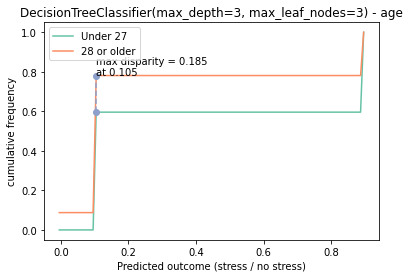

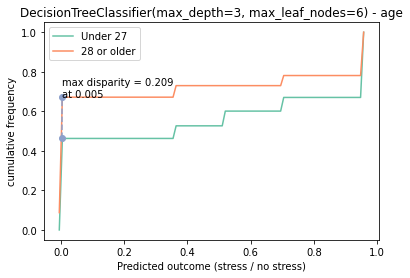

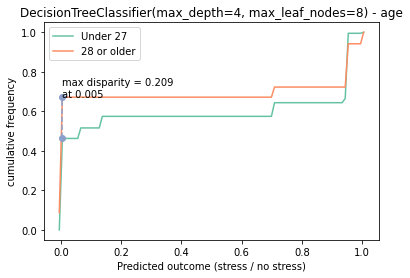

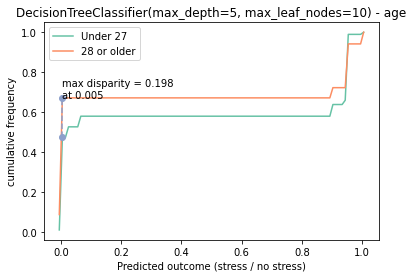

In [41]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  plot_and_compare_cdfs(y_pred, age, title=str(model) + ' - age', legend=['Under 27', '28 or older'])

As seen in the analysis, the models have less and less disparity between `age` groups as the `max_depth` and `max_leaf_nodes` increase. Meaning that the models become fairer on predictions between different age groups. Now let's visualize for `gender`.

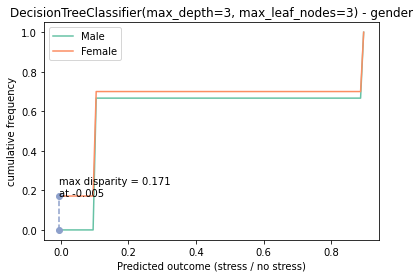

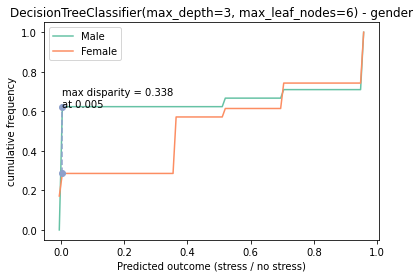

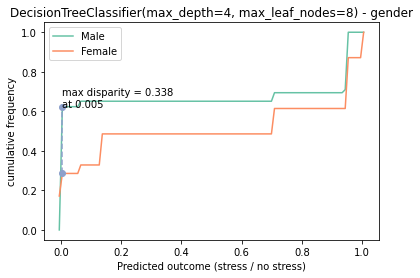

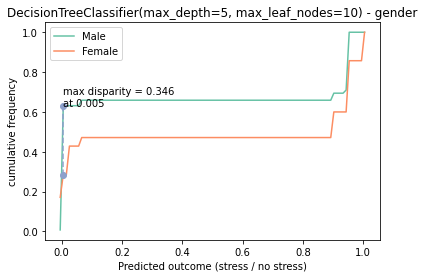

In [42]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  plot_and_compare_cdfs(y_pred, gender, title=str(model) + ' - gender', legend=['Male', 'Female'])

If we look at `gender` we can see the opposite happening, the difference in disparity becomes ever more slightly bigger as the `max_depth` and `max_leaf_nodes` increase. This is probably due to that the more decisions the model has, the more specifically it can predict. As we have a training set that is inbalanced in terms of `gender` representation this chance becomes bigger that the model bias-learned from the data and therefore bias predicts based on `gender`. 

The next step is to try de-biasing the models on `age` and `gender`.

## 4.3 De-biasing the models 
With the performance metrics interpreted, we can focus on de-biasing the model. Currently our models use the sensitive attributes `gender` and `age` to predict if a subject is stressed or not. Based on the analysis above we found that these attributes influence the prediction-making process. For example we found that there is a Population bias present in the current data in the form of the `gender` attribute having far more males than females. 

Therefore, we suggest to De-bias the model making the following improvements on the input data:
- Determining beforehand the independent attributes that go in to the model meaning that we will drop the `gender` & `age` all together making the model unaware of `gender` and `age` (fairness through unawareness) 
- We bias-learn with the model towards class-specific outcomes in `age` by reweighting the `age` column, making the model classification more fair. 
- We bias-learn with the model towards class-specific outcomes in `gender` by reweighting the `gender` column, making the model classification more fair. 


As a starting point we will do an analysis on the last two points `age` and `gender`. 


In [43]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)

pip install 'aif360[LawSchoolGPA]'


In [44]:
# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}

## Fairness analysis on `age`
Starting with the fairness analysis on sensitive attribute `age`.  

In [45]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df_may, 
                                         label_name="label",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['age'], 
                                         privileged_classes= [lambda x: x == 0],
                                         features_to_drop=['subject'])

For good explanation as we use an different module for learning this time namly `aif360`. Using this module we create a new dataset using our current `df_may` dataset called `ds_aif`. `ds_aif` dataset is different in the following aspects:
- favors specific `label` classifications of stressed (1) above no stress 
- With `protected_attributes_names = age` and `privilaged_classes` indicates that the `age` attributes has an privileged value `0 = under 27`, compared to `1 = 28 or older`. 
- the `subject` feature is dropped from this dataset  

Now we have an dataset which indicated possible demograpic age bais in the data. We can now use bais-learning on `age` attribute within this set in order to create an more fairer model. 

In [46]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

Split the data in 67% training and 33% test data. 

In [47]:
unpriv = [{'age': 1}]
priv = [{'age': 0}]

RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

Create the an unprivileged group (28 or older) and a privileged group (below 27) and fit this into a new trainingset. 

In [48]:
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [49]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

We create a new trainingset including the instance weights between the different age groups. Next, we will validate using the test data how the models perform in terms of FNR, FPR, TPR and TNR using an confusion matrix.  

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

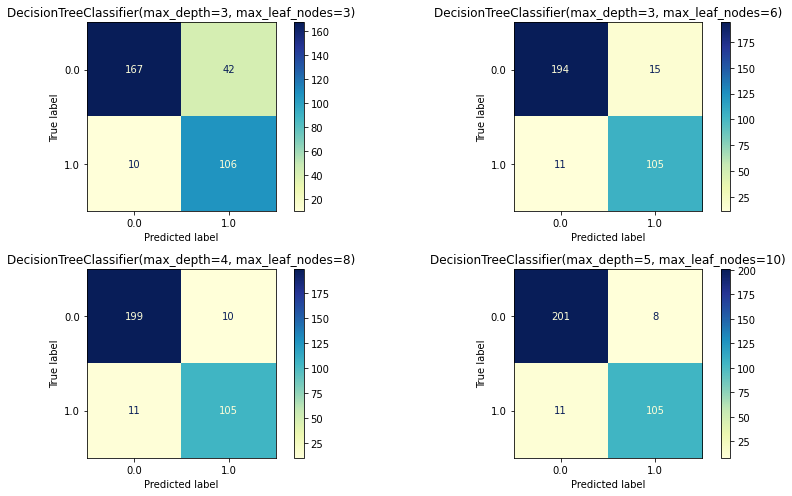

In [50]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(cls)

plt.tight_layout()
plt.show()

Based on the four confusion matrixes, we can observe the following:

- Overall the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` perform better in terms of predicting stress or no stress. 
- `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` both perform almost similar 
- `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` performs the worst with 167 TN and 106 TP. However, it has the least false negatives (only 1 less than the other three models).
- Comparing the number of TN and TP for `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` is almost performing equally well as `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`. 

Overall the decision trees have similar scores in using the reweighted `age` groups. Let's look at the classification report in order to see the trade-off between FN, FP, TN, TP's. 

In [51]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
               precision    recall  f1-score   support

         0.0       0.94      0.80      0.87       209
         1.0       0.72      0.91      0.80       116

    accuracy                           0.84       325
   macro avg       0.83      0.86      0.83       325
weighted avg       0.86      0.84      0.84       325

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       209
         1.0       0.88      0.91      0.89       116

    accuracy                           0.92       325
   macro avg       0.91      0.92      0.91       325
weighted avg       0.92      0.92      0.92       325

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       209
         1.0       0.91      0.91      0.91       116

    accurac

As the confusion matrix is showing similar results for the reweighted age samples, the classifcation report indicates also similar results compared to the non-reweighted age samples. Based on the `f1-score` we observe that as the `max_depth` and `max_leaf_nodes` increase the `f1-score`.

All in all, the reweighted samples `age` do not really change the performance of the models, which means that the reweighing the sensitive attribute `age` doesn't really effect the overall performance. 

Next, we need to evaluate the fairness of models when the `age` attribute is reweighed. 

## Fairness evaluations - `age`
After the initial analysis we can evaluate the dataset having reweighted the `age` attribute for this we will use the Equalized_odds_difference, False negative rate difference, Balanced error rate difference,                 Demographic parity difference, Overall AUC, AUC difference, FPR, FNR, TPR and TNR as we did before. Besides this, we will look at the false positives / negatives and the decision threshhold for `age`.   

In [52]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

We create an copy of the data test set and then with the code below, we fit the data again, make an prediction, determine the scores and metrics.  

In [53]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}') # change age<> gender
  print(f'Age:{chr(10)}{cls}: {chr(10)} {metric_frame (age)} {chr(10)}') # change age<> gender


  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=age)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.029207
False negative rate difference                 0.024242
Balanced error rate difference                 0.002482
 ------                                                
Demographic parity difference                   0.01751
  ------                                               
Overall AUC                                    0.856418
AUC difference                                 0.002482 

Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
           FPR       FNR       TPR       TNR
age                                        
0    0.213115  0.075758  0.924242  0.786885
1    0.183908  0.100000  0.900000  0.816092 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
      accuracy  false positive rate  false negative rate  selection rate  \
age                                                          

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Age:
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.009091
False negative rate difference                 0.009091
Balanced error rate difference                 0.002944
 ------                                                
Demographic parity difference                    0.0066
  ------                                               
Overall AUC                                    0.928663
AUC difference                                 0.002944 

Age:
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
           FPR       FNR       TPR       TNR
age                                        
0    0.049180  0.090909  0.909091  0.950820
1    0.045977  0.100000  0.900000  0.954023 

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8):
      accuracy  false positive rate  false negative rate  selection rate  \
age                                                          

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Now we see some interesting developments. As the samples are now reweighted on `age`. We see that compared to first EOD, FNRD, BER and DP analysis without reweighting the models with the reweighed age groups perform much better in terms predicting equal results both age groups. 

We see for the `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` that it has an very low EOD, FNRD, BER and DP for `age`, but still an very high FPR and FNR. Meaning that the model makes quite equal predictions for both age groups, but compared to the other models still makes many wrong predictions per age group. 

The `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` also made an big improvement in reweighting the sensitive attribute of `age` in terms of EOD, FNRD, BER and DP compared to non-reweighted model samples, but also makes quite equal predictions for both age groups, but compared to the other models still makes many wrong predictions per age group.

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` are the big winners of this age reweighting both models have around 0% EOD, FNRD, BER and 2%, 1% DP, respectivly. Meaning that both models make equal predictions foreach age group. Besides this, both models have an very low FPR and very high TPR and TNR. But both models have still an high FNR overall, meaning that the models don't predict stress while it should have been stress. 

All in all reweighting the `age` attribute really improved the EOD, FNRD, BER, and DP for all models. But in terms of FPR, FPR, TPR and TNR do not much improve after `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`, meaning that increasing the `max_depth` and `max_leaf_nodes` do not really improve the performance of the reweighted models overall, but we can conclude that the decsion trees become more fairer. 

Next up we will look at the post processing methodes to try optimizing the above results, starting with re-initilizing our training, test and sensitive feature of `age`.

In [54]:
# # set test & train data & defining age as sensitive attribute - UNAWARE

X = df_may.drop(columns=['gender', 'age', 'label', 'height', 'weight'])
y = df_may['label']

A = df_may[['age']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.33, 
    random_state=42)

for model in classifiers:
  model.fit(X_train, y_train)

For the independent variables we will drop `gender`, `age`, `label`, `height` and `weight`. The dropping of `gender`, `height` and `weight` makes the model train without being aware of the sensitive attributes (fairness through unawareness). Next up we will create our training, test and sensitive feature sets and refit the models.

Now with the models fitted using the new trainingsdata we will look at optimizing the previous results using the postprocessing methods of ExpontiatedGradient and decision Threshhold optimization. 

### Postprocessing - ExponentiatedGradient - Age
The exponentiatedGradient (EG) is an algoritm add fairness constraints to the optimization problem that the Decision Trees are trying to resolve. The code below creates an Exponentiated Gradient estimator and fits it with the training data. This EG estimator will try to optimize the FPR and FNR having a constraint that the false positive rate (FPR) or false negative rate (FNR) for different `age` groups is within 0.01%. 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
     ExponentiatedGradient                                          \
                 accuracy false positive rate false negative rate   
age                                                                 
0                0.851064            0.141667            0.161765   
1                0.868613            0.031915            0.348837   

                                               
    selection rate  count balanced error rate  
age                                            
0         0.393617  188.0            0.848284  
1         0.226277  137.0            0.809624  

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) difference:
 accuracy                0.017549
false positive rate     0.109752
false negative rate     0.187073
selection rate          0.167340
count                  51.000000
balanced error rate     0.038660
dtype: float64

Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
               

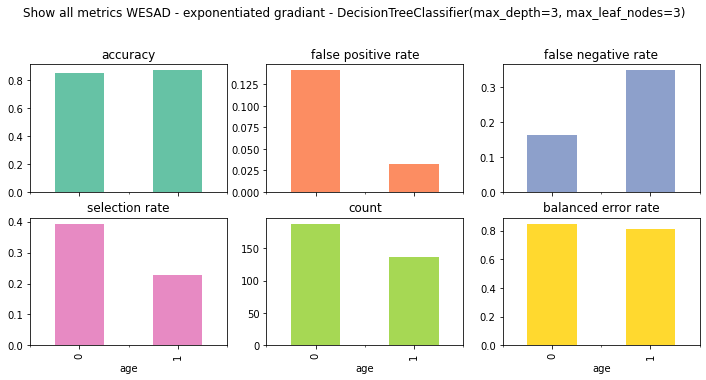

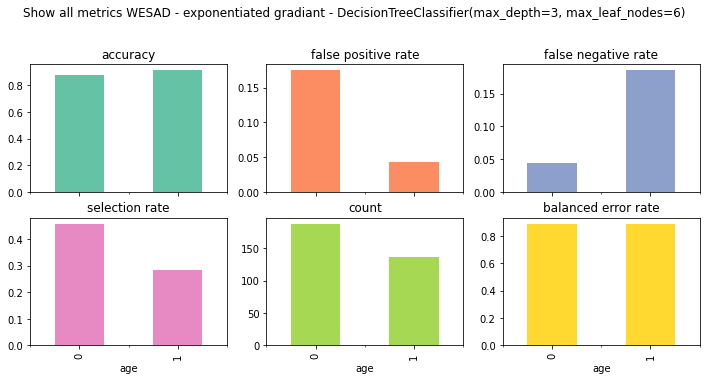

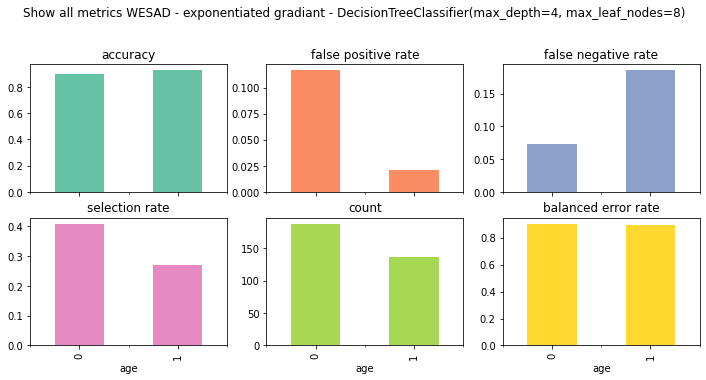

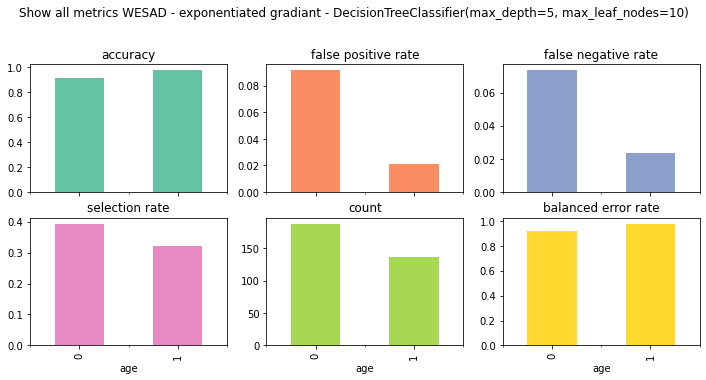

In [55]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) 
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       ) 
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



  # # y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') # change age<> gender

Looking at the results and comparing the FPR and FNR with the reweighted `age` results above, we can observe the following:

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)`:
- age group under 27 has an FPR of 14% and FNR of 16%
- age group 28 or above has an FPR of 3% and FNR 34%

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`: 
- age group under 27 has an FPR of 17% and FNR of 4% 
- age group 28 or above has an FPR of 4% and FNR of 18% 

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`:
- age group under 27 has an FPR of 17% and FNR of 4% 
- age group above 28 has an FPR of 4% and FNR of 18% 

`DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`:
- age group under 27 has an FPR of 9% and FNR of 7%
- age group under 27 has an FPR of 2% and FNR of 2%

All in all we see that the EG optimization reduces the FPR and FNR when the `max_depth` and `max_leaf_nodes` increase thereby enhances the trees performance in terms of demographic parity and equalized odds, but not necessarily in total accuracy. By comparing the FPR and FNR of the reweighted results above we can conclude that the EG solution performs worst comparing to the reweighted results. 

Next we will look at the Threshold optimizer for the `age` to optimize the decision outcomes of each tree. 


### Postprocessing - Threshold optimizer - Age
We will use the threshold optimizer algoritme to adjust the decision (stress or no stress) our trees make in order to balance the trade-off between accuracy and fairness. In the following code we iterate over each tree and create an unmitigated pipeline for it and fit it with our data. Then we create an ThresholdOptimizer (TO) to optimize based on equalized_odds an balanced accuracy score for each tree.  



DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
age                                                                             
0             0.840426            0.158333            0.161765       0.404255   
1             0.846715            0.074468            0.325581       0.262774   

                                
     count balanced error rate  
age                             
0    188.0            0.839951  
1    137.0            0.799975  

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) difference:
 accuracy                0.006290
false positive rate     0.083865
false negative rate     0.163817
selection rate          0.141482
count                  51.000000
balanced error rate     0.039976
dtype: float64

Age:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
                              

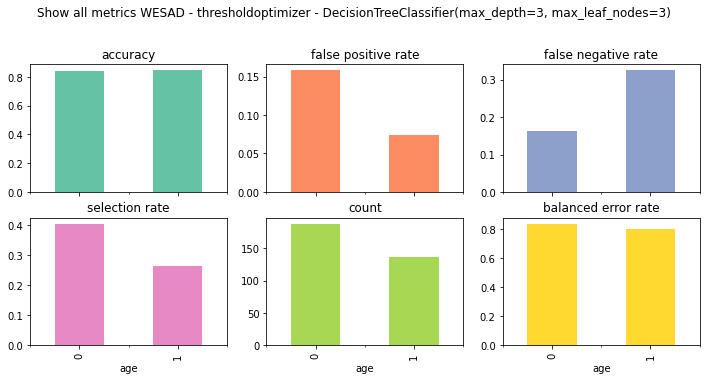

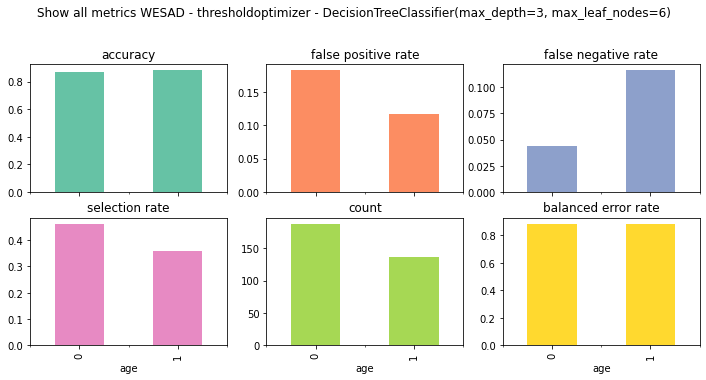

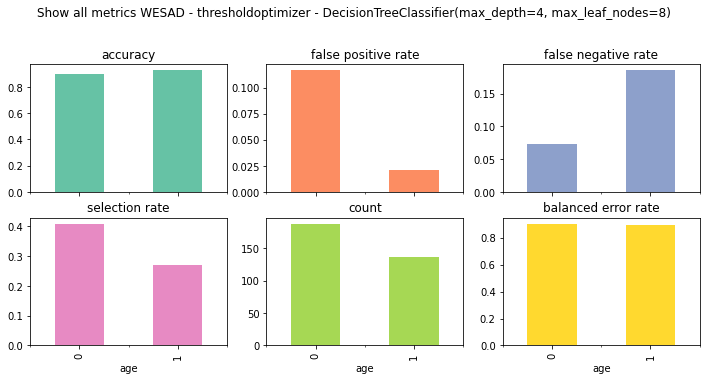

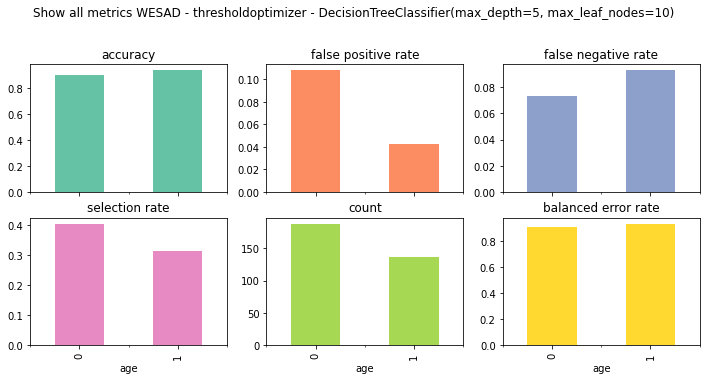

In [56]:
for cls in classifiers:
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) 

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) 
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f'Age:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
    )

The threshold optimizer seems to be able to reduce the variance in the false negative rate, false positive rate, and balanced error rate for `age` groups, but the trees overall accuracy is slightly decreased. 

Comparing the EG and TO optimizers for `age` in terms of fairness the Exponentiated Gradient method shows better results overall in terms of equalized odds difference, false negative rate difference, demographic parity difference, and balanced error rate difference. The overall AUC is also better in the ExponentiatedGradient method making the EG method an better optimizilzation method compared to threshold optimizer. 

Next we will look at the fairness analysis on `gender`.

## Fairness analysis on `Gender`
After the initial analysis we can evaluate the dataset having reweighted the `gender` attribute for this we will use the Equalized_odds_difference, False negative rate difference, Balanced error rate difference, Demographic parity difference, Overall AUC, AUC difference, FPR, FNR, TPR and TNR as we did before. Besides this, we will look at the false positives / negatives and the decision threshhold for `gender`. 

In [57]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset(df_may, 
                                         label_name="label", # 0 = no stress, 1 = stress
                                         favorable_classes = [1], # main goal: we want to know if someone is stressed
                                         protected_attribute_names=['gender'], # there are more males than females
                                         privileged_classes= [lambda x: x == 0], # males are privileged, female are unprivileged
                                         features_to_drop=['subject']) # drop the subject attribute 

For good explaination as we use an different module for learning this time namly `aif360`. Using this module we create an new dataset using our current `df_may` dataset called `ds_aif`. `ds_aif` dataset is different in the following aspects:
- favors specific `label` classification of stressed (1) above no stress 
- With `protected_attributes_names = gender` and `privilaged_classes` indicates that the `gender` attributes has an privileged value `0 = males`, compared to `1 = female`. 
- the `subject` feature is dropped from this dataset  

Now we have an dataset which indicated possible demograpic gender bais in the data. We can now use bais-learning on `gender` attribute within this set in order to create an more fairer model.  

In [58]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

Again we split the data into trainset using 67% of the data and an testset using 33% of the data.  

In [59]:
unpriv = [{'gender': 1}]
priv = [{'gender': 0}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

Next, we indicate again which classification groups are privilage (males = 0) and unprivilage (female = 1). With the pre-processing done we reweight the `unprivileged_groups` and the `privilaged_groups` before creating an training set.  

In [60]:
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

Refit rfc model & get metrics using reweighted training and testing sets

In [61]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

As we done in chapter 2 where we created the stress model, we again create an new X_train, Y_train, X_test, and Y_test but now reweighted, next to this we also create an w_train which indicates the instance_weights of the sensitive attribute `gender`   

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

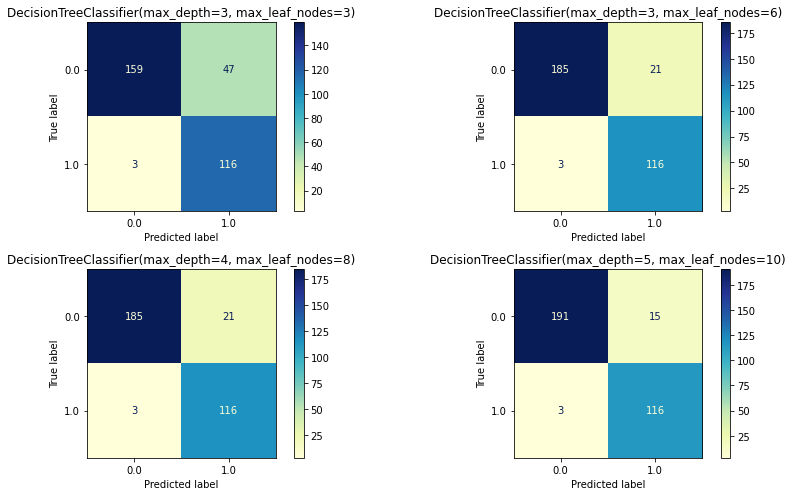

In [62]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(cls)

plt.tight_layout()
plt.show()

Based on the four confusion matrixes reweighting `gender`, we can observe the following:

- Overall the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10)` perform better in terms of predicting stress or no stress. 
- `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10)` both perform almost simulair 
- `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` performs the worst with 159 TN and 116 TP
- `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` has a very high amount of FP's (40) compared to the other trees, meaning that this tree is predicting no stress while in reality the subject feels stressed. 
- Comparing the number of TN and TP for `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` is almost performing equally well as `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10)`. Which is similar to the reweighed `age` confusion matrix result.  

Let's look at the classification report in order to see the trade-off between FN, FP, TN, TP's. 

In [63]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  print(f'{cls} - Gender: {chr(10)} {classification_report(y_test, y_pred)}')

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) - Gender: 
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86       206
         1.0       0.71      0.97      0.82       119

    accuracy                           0.85       325
   macro avg       0.85      0.87      0.84       325
weighted avg       0.88      0.85      0.85       325

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6) - Gender: 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       206
         1.0       0.85      0.97      0.91       119

    accuracy                           0.93       325
   macro avg       0.92      0.94      0.92       325
weighted avg       0.93      0.93      0.93       325

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8) - Gender: 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       206
         1.0       0.85      0.97      

Comparing with the previous classification report in chapter 2 the overall results looking at the `f1 score` are simailair which is a good sign meaning that the model didn't trade-off in classifications for by reweighting the `gender` attribute, in some cases it even achieved better results. Now, let's evaluate the fairness for `gender`. 

### Fairness evaluations - Gender
In order to validate the fairness we need to evaluate the reweighted `test` set. For this we will loop over each classifier and determine each metric frame and evaluate based on `gender`.

In [64]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

Create an copy test prediction from the current test set.  

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.036025
False negative rate difference                 0.031915
Balanced error rate difference                  0.03397
 ------                                                
Demographic parity difference                  0.020168
  ------                                               
Overall AUC                                    0.873317
AUC difference                                  0.03397 

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.236025  0.031915  0.968085  0.763975
1       0.200000  0.000000  1.000000  0.800000 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
         accuracy  false positive rate  false negative rate  selection rate  \
gender                                  

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.045135
False negative rate difference                 0.031915
Balanced error rate difference                 0.038525
 ------                                                
Demographic parity difference                  0.027451
  ------                                               
Overall AUC                                    0.936424
AUC difference                                 0.038525 

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.111801  0.031915  0.968085  0.888199
1       0.066667  0.000000  1.000000  0.933333 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6):
         accuracy  false positive rate  false negative rate  selection rate  \
gender                                  

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Gender:
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.045135
False negative rate difference                 0.031915
Balanced error rate difference                 0.038525
 ------                                                
Demographic parity difference                  0.027451
  ------                                               
Overall AUC                                    0.936424
AUC difference                                 0.038525 

Gender:
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.111801  0.031915  0.968085  0.888199
1       0.066667  0.000000  1.000000  0.933333 

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8):
         accuracy  false positive rate  false negative rate  selection rate  \
gender                                  

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


Gender:
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.031915
False negative rate difference                 0.031915
Balanced error rate difference                 0.019891
 ------                                                
Demographic parity difference                  0.003922
  ------                                               
Overall AUC                                    0.950987
AUC difference                                 0.019891 

Gender:
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.074534  0.031915  0.968085  0.925466
1       0.066667  0.000000  1.000000  0.933333 

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10):
         accuracy  false positive rate  false negative rate  selection rate  \
gender                               

/usr/local/lib/python3.8/dist-packages/fairlearn/metrics/_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


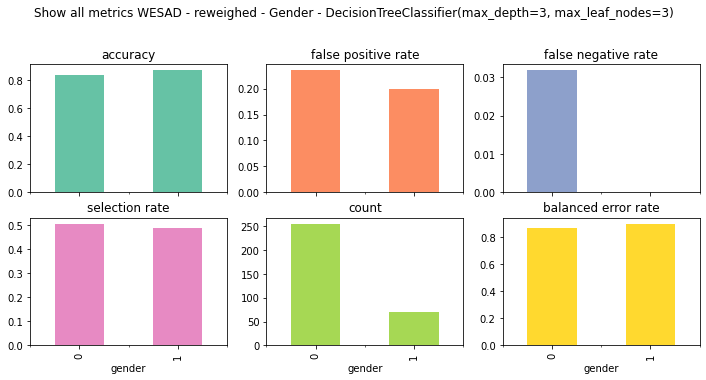

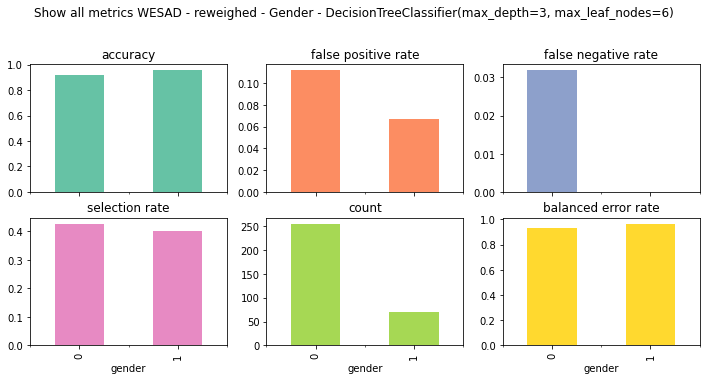

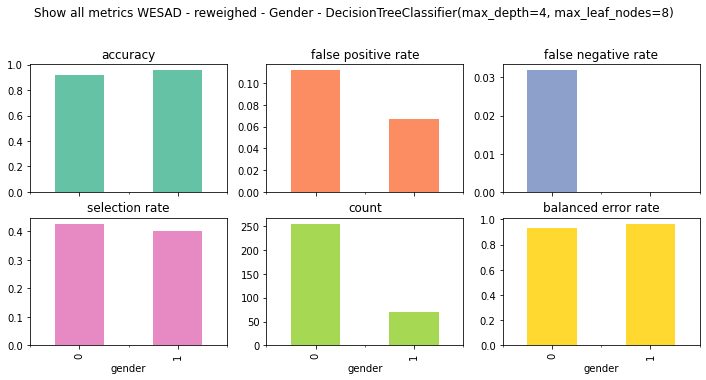

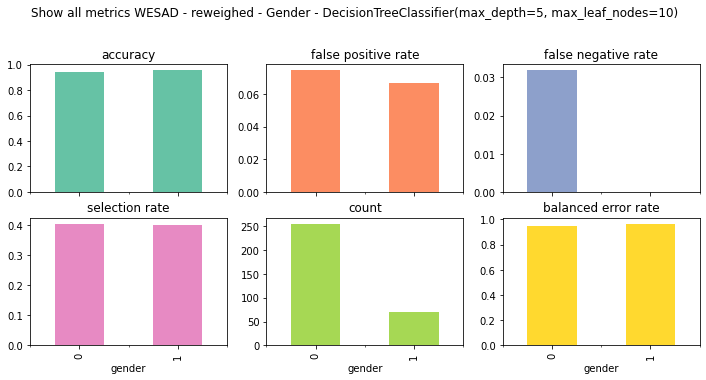

In [65]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}')
  print(f'Gender:{chr(10)}{cls}: {chr(10)} {metric_frame (gender)} {chr(10)}') 


  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=gender)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")



  # visualize mitigated
  mf1.by_group.plot(kind="bar",
                #   ylim=[0, 1],
                    subplots=True,
                    layout=[3, 3],
                    legend=False,
                    figsize=[12, 8],
                    title=f'Show all metrics WESAD - reweighed - Gender - {cls}',
                    )

Based on the visualiation, we can observe the following:
- `accuracy` is quite similair comparing each model 
- `false postive rate` is higher for female classification than male, meaning that based on the test set that females are more indicated of having stress than males, while that is not the case 
-  `false negative rate` classification is in general rate higher by males than females, meaning that for males classifications no stress is predicted, while it should predicted stress. 
- `selection rate` for woman decreases as `max_depth` and `max_leaf_nodes` of the tree increase, indicating the reweighted attribute `gender` do not outweight the other features, meaning that there is an limit on the reweighting of `gender` attribute 
- `count` indicates that females are still unrepresented in the dataset 
-  the `balance error rate difference` is the measure that measures the `stress` and `no stress` classification using `gender` or not. The balance error rate decreases as the `max_depth` and `max_leaf_nodes` increase meaning that the decision trees `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` performs better in terms of balancing the false positive and false negative rates

Comparing the results of reweighed `gender` attribute the unweighted results on EOD, FNRD, BER and DP we can observe that for the `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` the EOD, FNRD, BER, and DP meaning that the model makes much more fairer decisions, but at the cost of quite high FPR and FNR compared to the other models. 

The `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` reweighted vs un-reweighted results show that the EOD, FNRD, BER and DP almost decreased to an minimum of around 3% compared to 28% for un-weighted model. Meaning that compared to the un-weighted model the reweighted model is much fairer with even better performance in FPR, FNR, TPR, TNR. 

Looking at the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` we observe similair scores in terms of EOD, FNRD, BER, and DP with both models using the reweighed `gender` data slightly improving compared using the un-weighted `gender` attribute in both models. 

Overall we can conclude that increasing the `max_depth` and `max_leaf_nodes` will make the model slightly more fair. The models `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` & `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` are considered to be the fairest, but not by much. We can also conclude that the reweighting of the `gender` attribute made models very fair towards `male` and `female` predictions.

With the pre-processing analysis done, we can look at Fairlearn postprocessing methods to report false positives / negatives for `gender` and Fairlearn postprocessing methods for optimising the decision threshold for `male` and `female`.  

### Postprocessing - Exponentiated gradient - Gender
The exponentiatedGradient (EG) is an algoritm add fairness constraints to the optimization problem that the Decision Trees are trying to resolve. The code below creates an Exponentiated Gradient estimator and fits it with the training data. This EG estimator will try to optimize the FPR and FNR having a constraint that the false positive rate (FPR) or false negative rate (FNR) for different `gender` groups `male` and `female` is within 0.01%

In [66]:
# set test & train data & defining age as sensitive attribute - UNAWARE

X = df_may.drop(columns=['gender', 'age', 'label', 'height', 'weight'])
y = df_may['label']

A = df_may[['gender']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.33, 
    random_state=42)
# retrain the current decision trees again 
for model in classifiers:
  model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
        ExponentiatedGradient                                          \
                    accuracy false positive rate false negative rate   
gender                                                                 
0                    0.87451            0.067416            0.259740   
1                    0.80000            0.138889            0.264706   

                                                  
       selection rate  count balanced error rate  
gender                                            
0            0.270588  255.0            0.836422  
1            0.428571   70.0            0.798203  

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) difference:
 accuracy                 0.074510
false positive rate      0.071473
false negative rate      0.004966
selection rate           0.157983
count                  185.000000
balanced error rate      0.038219
dtype: float64

:
DecisionTreeClassifier(max_depth=3, ma

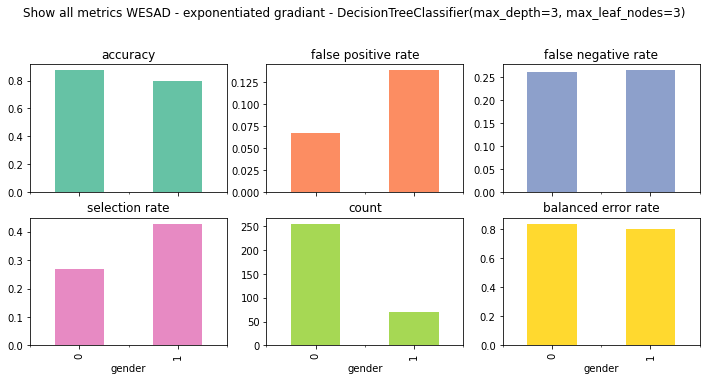

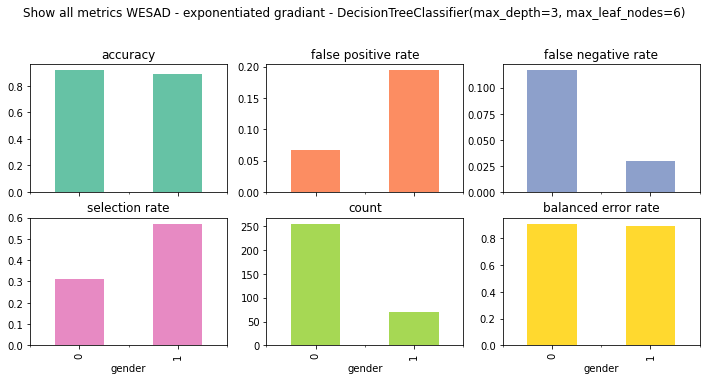

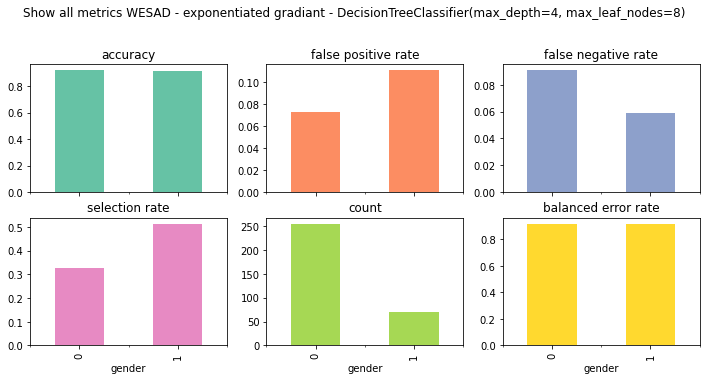

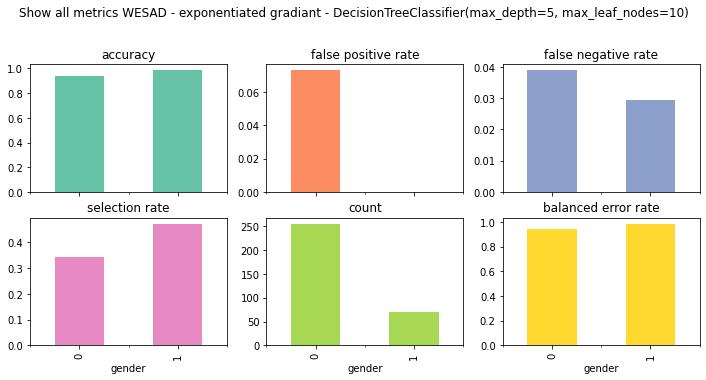

In [67]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) 
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       ) 
  
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print(f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")

  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )

  # y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

Looking at the results and comparing the FPR and FNR with the reweighted `gender` results above, we can observe the following:

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)`:
- age group under 27 has an FPR of 6% and FNR of 25%
- age group 28 or above has an FPR of 13% and FNR 26%

`DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)`: 
- age group under 27 has an FPR of 6% and FNR of 11% 
- age group 28 or above has an FPR of 19% and FNR of 2% 

`DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)`:
- age group under 27 has an FPR of 7% and FNR of 6% 
- age group above 28 has an FPR of 11% and FNR of 5% 

`DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)`:
- age group under 27 has an FPR of 7% and FNR of 3%
- age group 28 or older has an FPR of 0% and FNR of 2%

We can observe that increasing the `max_depth` and `max_leaf_nodes` will reduce the FPR and FNR using the EG, most notewortly is the 0% FPR on age group 28 or older for the `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` indicating that the performance of the tree is very good.  

Next we will look at the Threshold optimizer for the `gender` to optimize the decision outcomes of each tree. 

### Postprocessing - Threshold optimizer - Gender
We will use the threshold optimizer algoritme to adjust the decision (stress or no stress) our trees make in order to balance the trade-off between accuracy and fairness. In the following code we iterate over each tree and create an unmitigated pipeline for it and fit it with our data. Then we create an ThresholdOptimizer (TO) to optimize based on equalized_odds an balanced accuracy score for each tree.

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3):
        ThresholdOptimizer                                          \
                 accuracy false positive rate false negative rate   
gender                                                              
0                0.713725            0.134831            0.636364   
1                0.642857            0.166667            0.558824   

                                                  
       selection rate  count balanced error rate  
gender                                            
0            0.203922  255.0            0.614402  
1            0.300000   70.0            0.637255  

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3) difference:
 accuracy                 0.070868
false positive rate      0.031835
false negative rate      0.077540
selection rate           0.096078
count                  185.000000
balanced error rate      0.022852
dtype: float64

Gender:
DecisionTreeClassifier(max_depth=3, max_leaf_no

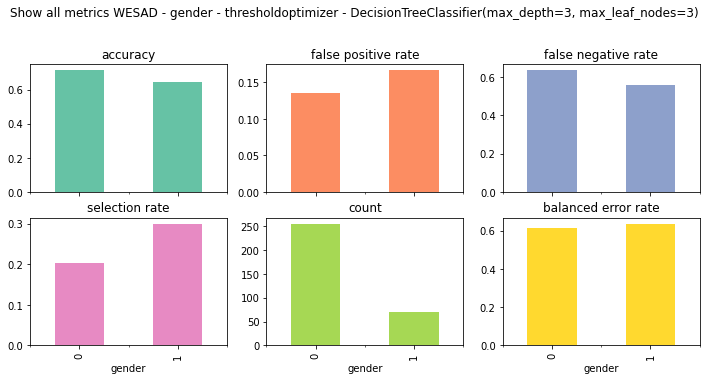

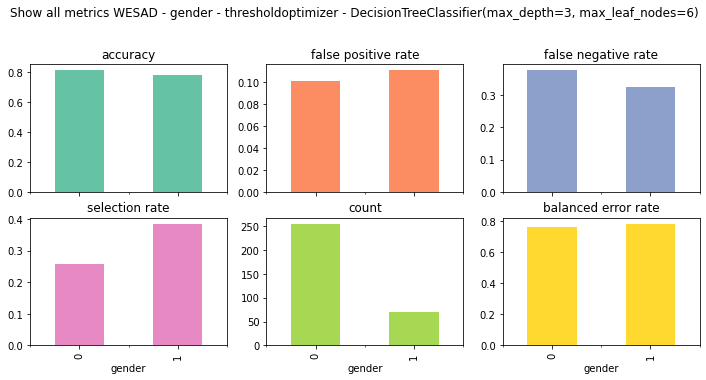

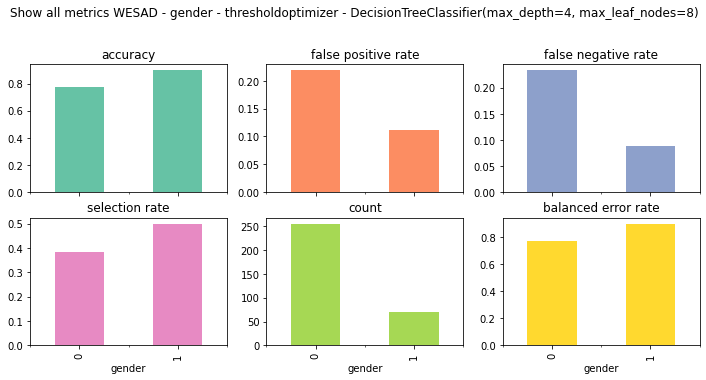

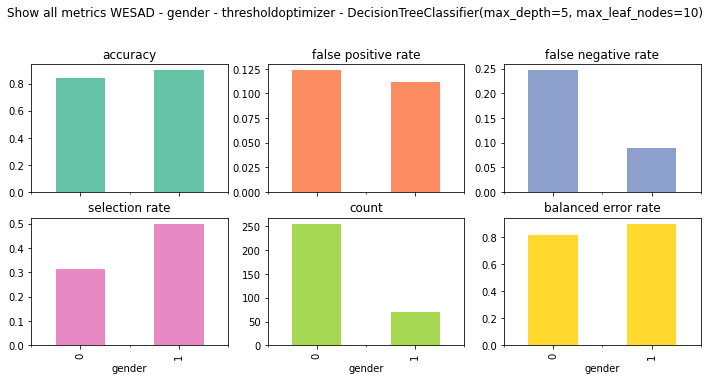

In [68]:
for cls in classifiers:
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) # gender<>age

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) # gender<>age
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') # change age<> gender

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - gender - thresholdoptimizer - {cls}',
    )

Based on the threshold optimizer results with can observe the following

The `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` performs the best among the four classifiers based on the provided predictions, having the highest accuracy, lowest false negative rate, and balanced error rate.

The `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` is the most fair of the four classifiers in terms of fairness, having the lowest demographic parity difference and balanced error rate difference. 

All in all it depends what the reseachers want based on this threshold optimizer in terms of performance and fairness. 

# 5. Overall Quality, Conclusion & Recommendations 
Based on our analysis we can conclude that the overall quality of the data is insufficient for predicting possible stress or not stress with the subject. The major problem that we faced during this analysis was the lack of data, mainly in terms of female samples and age samples of 28 or above. Making the data biased and inbalanced to start with, which would mean that if the four models will be used by the researcher, it would be likely generate unrealistic predictions. Currently the data inbalance will result in bias-in / bias-out for all models.      

Based on fairness, we can conclude that the reweighing of the `age` and `gender` attributes are greatly increasing the fairness of the decision tree models, where the increase in `max_depth` and `max_leaf_nodes` did influence the increase in performance, but not the increase in fairness. 

Overall, the `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` and `DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)` should be chosen in terms of performance and accuracy and in terms of fairness the `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)` and `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` are the best canditates. To conclude our analysis on performance vs fairness, the best candidate would be `DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)` with `reweighted age groups` and `reweighted gender` in terms of fairness having sufficient performance for corect predictions. However, `DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)` is a little worse in fairness and much better in terms of perdicting stress or no stress. 
 
Looking at the Exponentiated gradient and Decison threshold we can see that the reweighting of `age` and `gender` return a fairer and better performing result compared to the postprocessing optimization of these algoritms.  

For future analysis, we recommend to obtain more data on mainly subjects that are 28 years or older and female overall. This is very important to balance the data and to minimize the bias with in the model. Besides this, more data overall is required to train the model and therefore we suggest that the researchers start looking for similiar sensor data and merge it with the current data. 

The next recommendation is on the models on terms of fairness. As decision trees are quite bias-sensitive, we recommend other models like `RandomForest` or `Fairness-aware decision tree (FDT)` in order to improve performance and fairness.  